### Import all the stuff
you can get the matrixmethod used to calculate the refelctivity from here: https://github.com/mikapfl/matrixmethod
pint is not necessary but I like it to work with units

In [1]:
import sys
import os
from os import listdir
from os.path import isfile, join, expanduser
home = expanduser("~")
#sys.path.append(join(home,'Projects/helpfullscripts/'))
sys.path.append(join(home,'Projects/'))
sys.path.append('./python_files/')
#sys.path.append(home)
#sys.path.append('../')
#sys.path.append(r'C:\Users\Kas\Documents\GitHub')
#sys.path.append(r'C:\Users\Kas\Documents\GitHub\XRR_workflows\calculate_n_k_from_xrr')
import matrixmethod.mm_numba as mm
import numpy as np
import matplotlib.pyplot as plt
import xray_compounds as xc
import pandas as pd
import pint
unit = pint.UnitRegistry()
import scipy
import pickle 
import emcee
import tqdm
from multiprocessing import Pool
#import Divergence as div
from scipy.optimize import differential_evolution, minimize
from scipy.ndimage import gaussian_filter1d

In [2]:
#Do convert eV to nm
c = scipy.constants.c #speed of light
h = scipy.constants.h #Planck
e = scipy.constants.e #elemetry charge
hc = h*c/e*1e9 #wavelenght in nm
print(hc)
def eVnm_converter(value):
    #Planck's constant (6.6261 x 10-34 J*s) and c is the speed of light (2.9979 x 108 m/s)
    return hc/value

1239.8419843320025


### Import and standardize experimental data 

At the end of this step there should be an array containing the angles in deg and the reflectivity for each measured energy 

In [3]:
sample_name = '2layers' #the sample that we want to fit
path = './data/' #path to the reduced refelctivity data
onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('csv') and f.startswith(sample_name)]
print(onlyfiles_keys)

labels = []
exp_data_all = []

for file in onlyfiles_keys:
    label = file[:-4]  
    file = join(path, file)
    df = pd.read_csv(file)  
    if 'energy' in df.columns:
        df = df.rename(columns={'energy': 'Energy'})
    if 'sam_th' in df.columns:
        df = df.rename(columns={'sam_th': 'Theta'})


    # Average R over repeated (Energy, Theta) pairs, this should not be nescessarry
    
    df['R'] = df.groupby(['Energy', 'Theta'], as_index=False)['R'].transform('max')
    df = df.groupby('Energy', group_keys=False).apply(lambda group: group.sort_values(by='Theta'))

    df['file_name'] = label  
    df['E_round'] = np.round(df["Energy"], 1)
    # Apply filters
    df = df[df['Theta'] > 2.5]
    df = df[df['Theta'] < 27]
    df = df[df['R'] >= 0]

    labels.append(label)
    exp_data_all.append(df)


# Combine all data
combined_df = pd.concat(exp_data_all, ignore_index=True)
#combined_df = combined_df[combined_df['file_name'] != 'SOG5_002942'] #Exclude SOG5
#combined_df = combined_df[(combined_df['Energy'] < 284.7) | (combined_df['Energy'] > 285)] #Exclude energies if necessary 

all_energy = np.asarray(combined_df['Energy'])
energy_uni = np.unique(all_energy)

split_file = labels[0].split('_')
file_name = '_'.join(split_file[:3]) 

['2layers.csv']


/tmp/ipykernel_296642/2262292005.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Energy', group_keys=False).apply(lambda group: group.sort_values(by='Theta'))


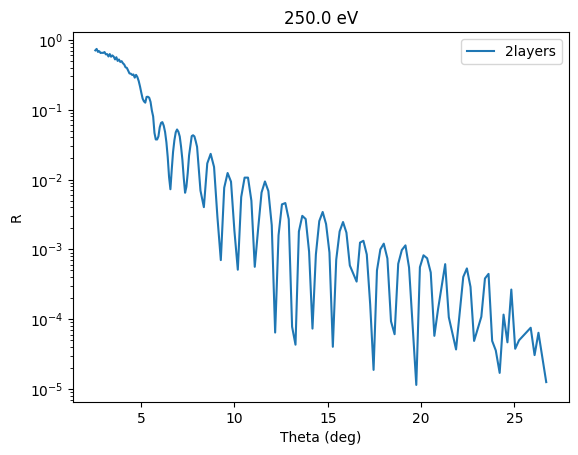

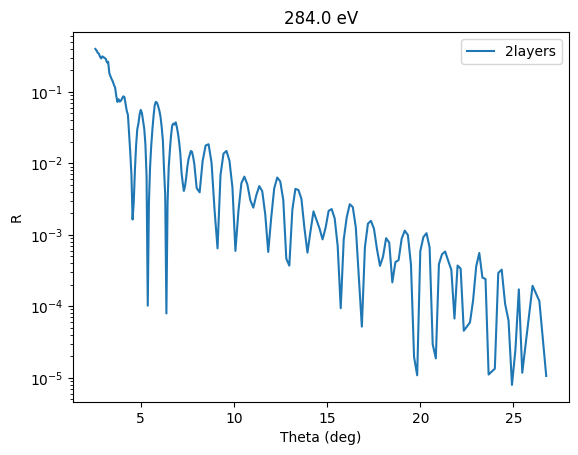

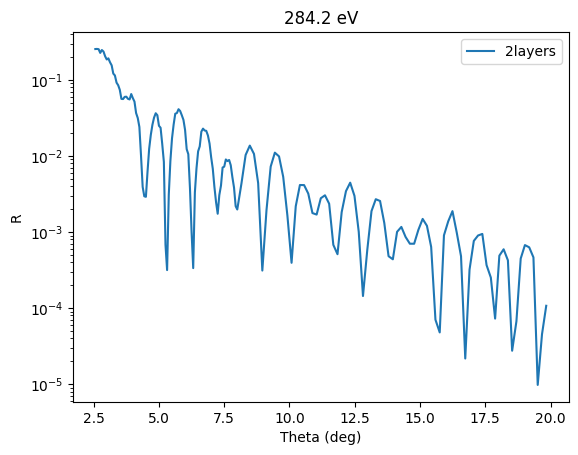

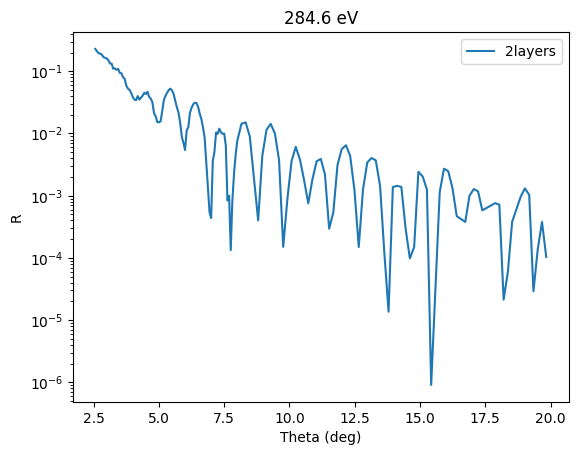

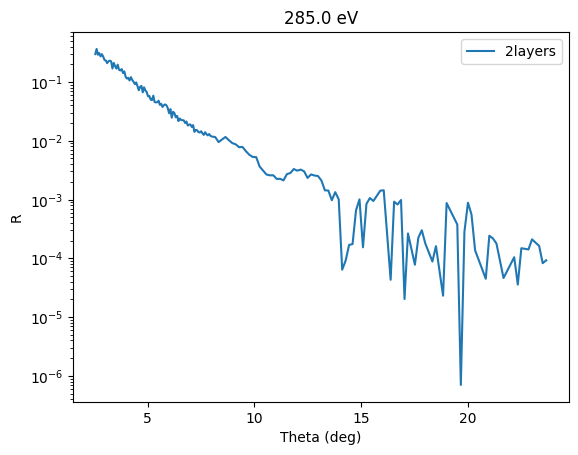

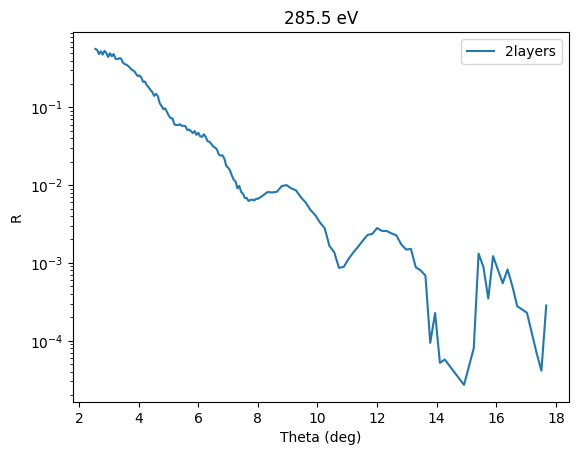

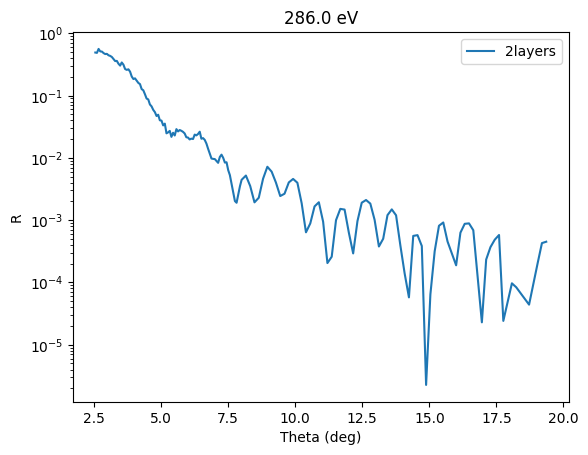

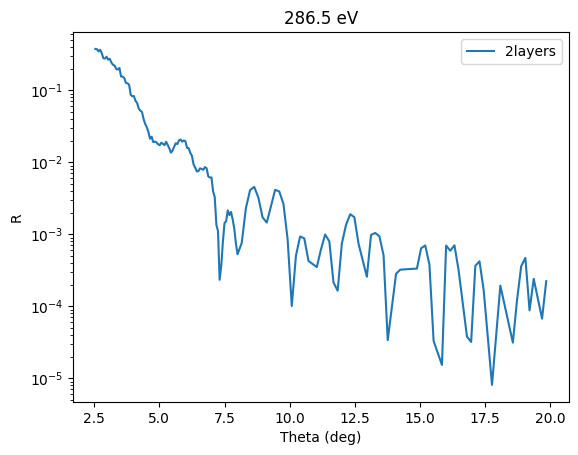

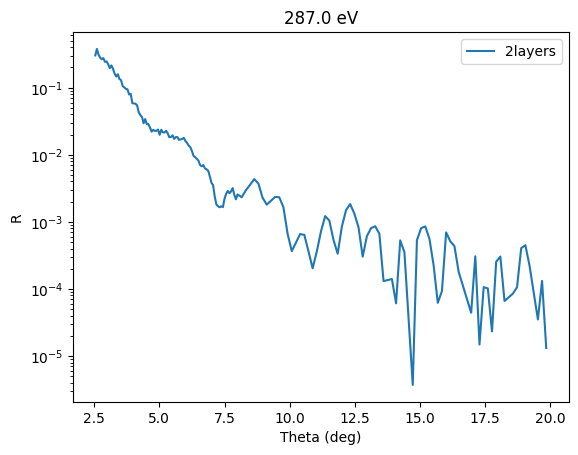

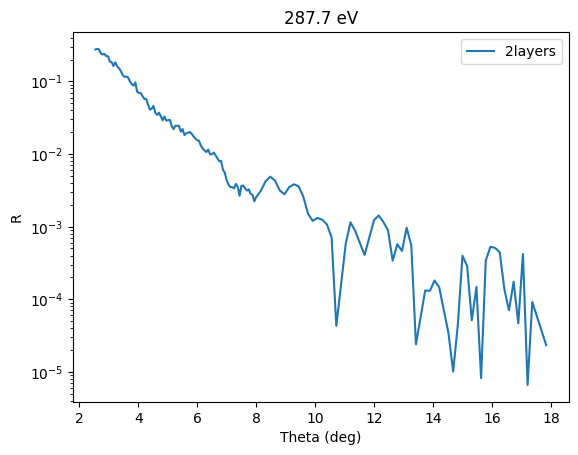

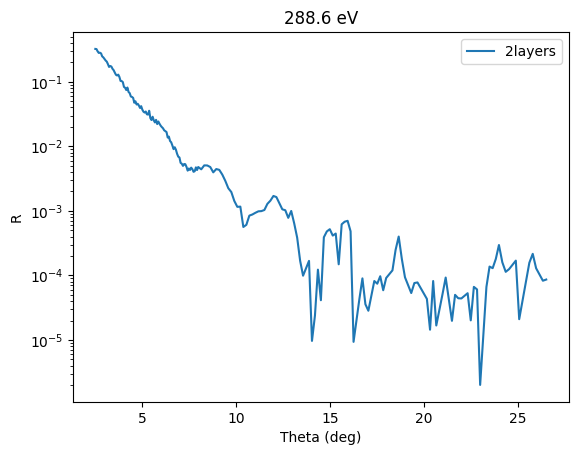

In [4]:
#Plot the relfectivity data for each energy
i_start = 0
i_end = -1
labels_uni = np.unique(labels)
for i,E in enumerate(energy_uni):
    xrr_all = combined_df[combined_df['E_round']==E] 
    for file in labels_uni:
        subset = xrr_all[xrr_all['file_name']==file]
        plt.plot(subset['Theta'][i_start:i_end],subset['R'][i_start:i_end],'-',label=file)
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Theta (deg)')
    plt.ylabel('R')
    plt.title(str(E)+ ' eV')
    #plt.axvline(x=1, color='cyan')
    plt.show()

In [5]:
#used to make sure they have the same energy
combined_df['E_round'] = np.round(combined_df["Energy"],1)
energy_uni = np.unique(combined_df['E_round'])

It may be necessary to use values from a database for the nk of e.g. the substrate for each measured energy / wavelength.
Accessing the database for the NK of the Si substrate can be look like this:

In [6]:

nk_sub = np.conjugate(xc.refractive_index('Si',energy_uni* unit.eV,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',energy_uni* unit.eV,density=2.0929729034348785))
print(1-nk_sub)
print(1-nk_sub_oxid)

[0.00597153-0.0042505j  0.00498743-0.00290475j 0.00498209-0.00289865j
 0.00497143-0.00288649j 0.00496081-0.0028744j  0.0049476 -0.00285935j
 0.00493444-0.0028444j  0.00492135-0.00282953j 0.00490821-0.00281487j
 0.00488985-0.00279453j 0.00486642-0.00276863j]
[0.00550014-0.0021266j  0.00437602-0.0014395j  0.00437035-0.0014364j
 0.00435903-0.00143021j 0.00434776-0.00142406j 0.00433373-0.00141641j
 0.00431978-0.0014088j  0.00430589-0.00140126j 0.00429202-0.00139381j
 0.00427269-0.00138347j 0.00424805-0.00137031j]


### Prepare the fit
In "domain_E" all the energy dependent fit parameter are defined with the domain the value is expected to be in and a possible start value ("x0"). Typical this are the nk of the resist.

In "domain" all the fit parameters indepent of the energy are defined. This are parameters like the thickness or roughness of the layers.

In the following the objective functions for the optimzation are defined. Here the optization is split into an inner and out optization (Bi level optization). The inner optimzation is for the energy dependent parameters and the outer for the energy indepent parameters.

## Run the fit

### Do inner fit


In [10]:
def get_nk_arrays(material=None, energy_uni=None, bounds_n=None, bounds_k=None, density=None):
    if material:
        # Use xraylib or xraydb to fetch refractive index
        nk_complex = np.conjugate(xc.refractive_index(material, energy_uni * unit.eV, density=density))
        n_array = np.real(nk_complex)
        k_array = np.imag(nk_complex)
    else:
        # Use mean of bounds
        n_array = np.mean(bounds_n) * np.ones_like(energy_uni)
        k_array = np.mean(bounds_k) * np.ones_like(energy_uni)

    return n_array, k_array


class LayerSpec:
    def __init__(self, name, is_substrate=False):
        self.name = name
        self.is_substrate = is_substrate
        self.params = {}
        self._nk_set = False

    def fit_thickness(self, x0, bounds):
        if self.is_substrate:
            raise ValueError(f"Layer '{self.name}' is marked as substrate and cannot have thickness.")
        self.params['thickness'] = {'fit': True, 'x0': x0, 'bounds': bounds}
        return self

    def fixed_thickness(self, value):
        if self.is_substrate:
            raise ValueError(f"Layer '{self.name}' is marked as substrate and cannot have thickness.")
        self.params['thickness'] = {'fit': False, 'value': value}
        return self

    def fit_roughness(self, x0, bounds):
        self.params['roughness'] = {'fit': True, 'x0': x0, 'bounds': bounds}
        return self

    def fixed_roughness(self, value):
        self.params['roughness'] = {'fit': False, 'value': value}
        return self
    
    def fit_nk_from_material(self, material, energy_uni, bounds_n, bounds_k, density=None):
        self._nk_set = True

        if material:
            nk_complex = np.conjugate(xc.refractive_index(material, energy_uni * unit.eV, density=density))
            n_array = np.real(nk_complex)
            k_array = np.imag(nk_complex)
        else:
            n_array = np.mean(bounds_n) * np.ones_like(energy_uni)
            k_array = np.mean(bounds_k) * np.ones_like(energy_uni)

        # Extend bounds to include x0
        def extend_bounds(x0_val, bound):
            lower, upper = bound
            return (min(lower, x0_val), max(upper, x0_val))

        bounds_n_extended = [extend_bounds(n_array[i], bounds_n) for i in range(len(n_array))]
        bounds_k_extended = [extend_bounds(k_array[i], bounds_k) for i in range(len(k_array))]

        self.params['n'] = {
            'fit': True,
            'x0': n_array,
            'bounds': bounds_n_extended
        }
        self.params['k'] = {
            'fit': True,
            'x0': k_array,
            'bounds': bounds_k_extended
        }
        return self

    
    def fixed_nk_from_material(self, material, energy_uni, density=None):
        nk_complex = np.conjugate(xc.refractive_index(material, energy_uni * unit.eV, density=density))
        n_array = np.real(nk_complex)
        k_array = np.imag(nk_complex)

        return self.fixed_nk(n_array, k_array)



    def fit_nk_array(self, n_array, k_array, bounds_n, bounds_k):
        self._nk_set = True
        self.params['n'] = {'fit': True, 'x0': n_array, 'bounds': [bounds_n] * len(n_array)}
        self.params['k'] = {'fit': True, 'x0': k_array, 'bounds': [bounds_k] * len(k_array)}
        return self

    def fixed_nk(self, n_array, k_array):
        self._nk_set = True
        self.params['n'] = {'fit': False, 'value': n_array}
        self.params['k'] = {'fit': False, 'value': k_array}
        return self

    def validate(self, energy_count):
        if not self._nk_set:
            raise ValueError(f"Layer '{self.name}' must define n and k arrays.")
        if self.params.get('n', {}).get('fit') and len(self.params['n']['x0']) != energy_count:
            raise ValueError(f"Layer '{self.name}' has mismatched n array length.")
        if self.params.get('k', {}).get('fit') and len(self.params['k']['x0']) != energy_count:
            raise ValueError(f"Layer '{self.name}' has mismatched k array length.")

class ReflectivityModel:
    def __init__(self, energy_points, layers, global_params=None):
        self.energy_points = energy_points
        self.layers = layers  # List of LayerSpec objects
        self.global_params = global_params or {}
        self.domain_E_init = []
        self.x0_dict = {}
        self.keys = {}

        self._validate_layers()
        self.energy_index_map = {float(E): i for i, E in enumerate(self.energy_points)}
        self._inject_layer_params()
        self._build_energy_domains()
        self._build_global_keys()
        

    def _validate_layers(self):
        for layer in self.layers:
            layer.validate(len(self.energy_points))
        
    def _inject_layer_params(self):
        for layer in self.layers:
            lname = layer.name

            # Thickness
            if 'thickness' in layer.params and layer.params['thickness']['fit']:
                self.global_params[f'thickness_{lname}'] = {
                    'fit': True,
                    'x0': layer.params['thickness']['x0'],
                    'bounds': layer.params['thickness']['bounds']
                }

            # Roughness
            if 'roughness' in layer.params and layer.params['roughness']['fit']:
                self.global_params[f'rough_{lname}'] = {
                    'fit': True,
                    'x0': layer.params['roughness']['x0'],
                    'bounds': layer.params['roughness']['bounds']
                }


    def _build_energy_domains(self):
        for layer in self.layers:
            lname = layer.name
            for i, E in enumerate(self.energy_points):
                if layer.params.get('n', {}).get('fit'):
                    self.domain_E_init.append({
                        'name': f'n_{lname}_{E}',
                        'x0': layer.params['n']['x0'][i],
                        'domain': layer.params['n']['bounds'][i]
                    })
                if layer.params.get('k', {}).get('fit'):
                    self.domain_E_init.append({
                        'name': f'k_{lname}_{E}',
                        'x0': layer.params['k']['x0'][i],
                        'domain': layer.params['k']['bounds'][i]
                    })
        for E in self.energy_points:
            self.x0_dict[E] = [d['x0'] for d in self.domain_E_init if f'_{E}' in d['name']]

    def _build_global_keys(self):
        for param, spec in self.global_params.items():
            if spec.get('fit'):
                self.keys[param] = spec['x0']
            else:
                self.keys[param] = spec['value']
        self.keys['x0'] = self.x0_dict
        self.keys['E_uni'] = self.energy_points

    def build_layer_arrays(self, E):
        layer = []
        rough = []
        n_stack = [1 + 0j]  # ambient

        i = self.energy_index_map[E]

        for layer_spec in self.layers:
            lname = layer_spec.name

            # Thickness
            if 'thickness' in layer_spec.params:
                if layer_spec.params['thickness']['fit']:
                    layer.append(self.keys[f'thickness_{lname}'])
                else:
                    layer.append(layer_spec.params['thickness']['value'])

            # Roughness
            if 'roughness' in layer_spec.params:
                if layer_spec.params['roughness']['fit']:
                    rough.append(self.keys[f'rough_{lname}'])
                else:
                    rough.append(layer_spec.params['roughness']['value'])

            # Optical constants
            if layer_spec.params['n']['fit']:
                n_real = self.keys[f'n_{lname}_{E}']
            else:
                n_real = layer_spec.params['n']['value'][i]

            if layer_spec.params['k']['fit']:
                n_imag = self.keys[f'k_{lname}_{E}']
            else:
                n_imag = layer_spec.params['k']['value'][i]


            n_stack.append(1 - n_real + n_imag * 1j)

        return np.array(layer), np.array(rough), np.array(n_stack)

In [11]:
model = ReflectivityModel(
    energy_points=energy_uni,
    layers=[
        LayerSpec("resist_1")
            .fit_thickness(35, bounds=(30, 45))
            .fit_roughness(0.009, bounds=(0, 2))
            .fit_nk_from_material('SiO4C8H20', energy_uni, bounds_n=(-0.05, 0.05), bounds_k=(0, 0.1), density=2.09),
        LayerSpec("resist_2")
            .fit_thickness(100, bounds=(90, 105))
            .fit_roughness(0.009, bounds=(0, 2))
            .fit_nk_from_material('C8H6O', energy_uni, bounds_n=(-0.05, 0.05), bounds_k=(0, 0.1), density=2.09),
        LayerSpec("oxide")
            .fixed_thickness(1.5)
            .fixed_roughness(1.0)
            .fixed_nk_from_material("SiO2", energy_uni, density=2.09),
        LayerSpec("substrate", is_substrate=True)
            .fixed_roughness(1.0)
            .fixed_nk_from_material("Si", energy_uni, density=2.33)
    ],
    global_params={
        'aoi_offset': {'fit': False, 'value': 0.0}, #{'fit': True, 'x0': 0.0, 'bounds': (-1, 1)},
        'darkcurrent': {'fit': False, 'value': 0.0},
        'a': {'fit': False, 'value': 0.045},
        'b': {'fit': False, 'value': 2.5e-5}
    }
)
model.keys

{'aoi_offset': 0.0,
 'darkcurrent': 0.0,
 'a': 0.045,
 'b': 2.5e-05,
 'thickness_resist_1': 35,
 'rough_resist_1': 0.009,
 'thickness_resist_2': 100,
 'rough_resist_2': 0.009,
 'x0': {np.float64(250.0): [np.float64(0.9946027716219834),
   np.float64(0.0008213748883226468),
   np.float64(0.9956937468404347),
   np.float64(0.00027527570835406617)],
  np.float64(284.0): [np.float64(0.9986505554032166),
   np.float64(0.0005413249298976751),
   np.float64(1.0017053399887552),
   np.float64(0.0001639908231735774)],
  np.float64(284.2): [np.float64(0.9987158123690838),
   np.float64(0.001374009839380527),
   np.float64(1.0018148518173116),
   np.float64(0.001634159220599101)],
  np.float64(284.6): [np.float64(0.998443008157571),
   np.float64(0.0021987223205703977),
   np.float64(1.0013226567433342),
   np.float64(0.0030919804174857632)],
  np.float64(285.0): [np.float64(0.9980822325432654),
   np.float64(0.002188865957688329),
   np.float64(1.0006753698812707),
   np.float64(0.00307801912250

[np.float64(0.9946027716219834), np.float64(0.0008213748883226468), np.float64(0.9956937468404347), np.float64(0.00027527570835406617)]
['n_resist_1_250.0', 'k_resist_1_250.0', 'n_resist_2_250.0', 'k_resist_2_250.0']


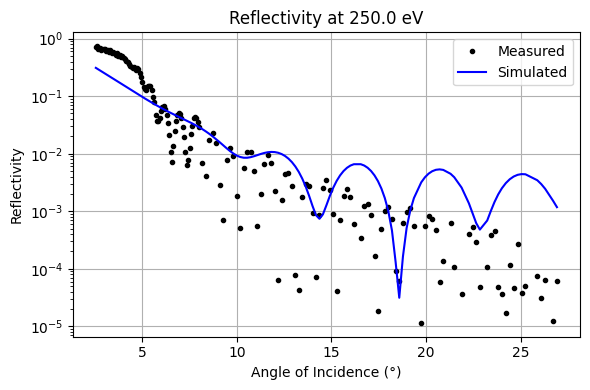

[np.float64(0.9986505554032166), np.float64(0.0005413249298976751), np.float64(1.0017053399887552), np.float64(0.0001639908231735774)]
['n_resist_1_284.0', 'k_resist_1_284.0', 'n_resist_2_284.0', 'k_resist_2_284.0']


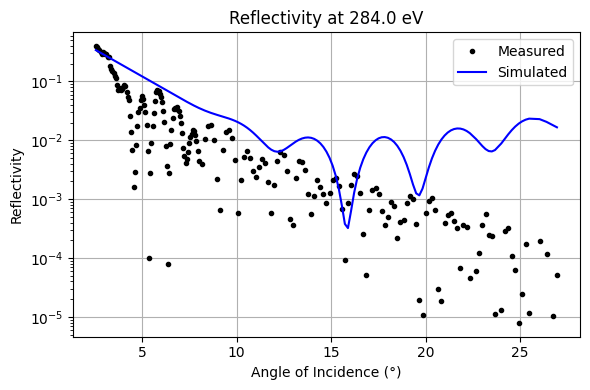

[np.float64(0.9987158123690838), np.float64(0.001374009839380527), np.float64(1.0018148518173116), np.float64(0.001634159220599101)]
['n_resist_1_284.2', 'k_resist_1_284.2', 'n_resist_2_284.2', 'k_resist_2_284.2']


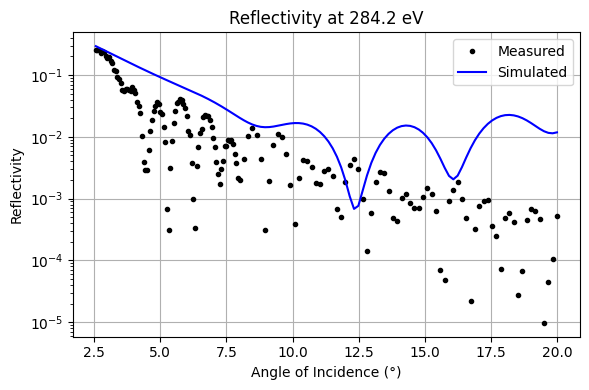

[np.float64(0.998443008157571), np.float64(0.0021987223205703977), np.float64(1.0013226567433342), np.float64(0.0030919804174857632)]
['n_resist_1_284.6', 'k_resist_1_284.6', 'n_resist_2_284.6', 'k_resist_2_284.6']


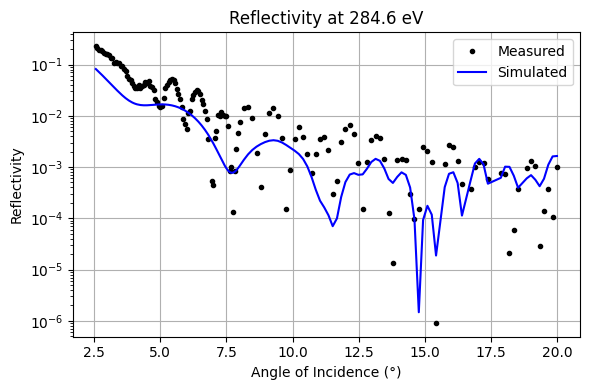

[np.float64(0.9980822325432654), np.float64(0.002188865957688329), np.float64(1.0006753698812707), np.float64(0.003078019122501298)]
['n_resist_1_285.0', 'k_resist_1_285.0', 'n_resist_2_285.0', 'k_resist_2_285.0']


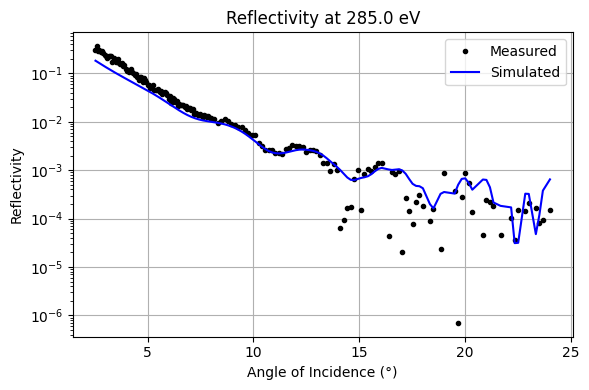

[np.float64(0.9976341123718802), np.float64(0.0021766109745248365), np.float64(0.9998713507446344), np.float64(0.0030606603650053413)]
['n_resist_1_285.5', 'k_resist_1_285.5', 'n_resist_2_285.5', 'k_resist_2_285.5']


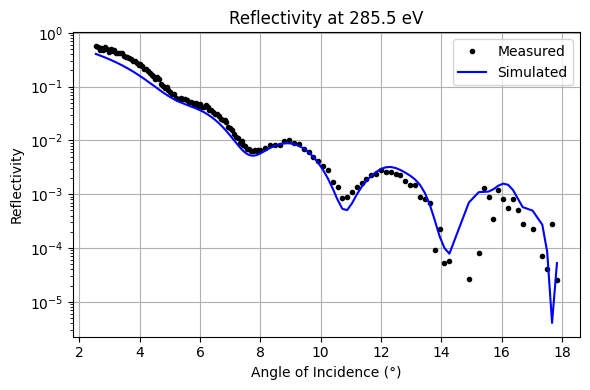

[np.float64(0.9971974336922361), np.float64(0.002164430451020825), np.float64(0.9990875798744863), np.float64(0.0030434076007040066)]
['n_resist_1_286.0', 'k_resist_1_286.0', 'n_resist_2_286.0', 'k_resist_2_286.0']


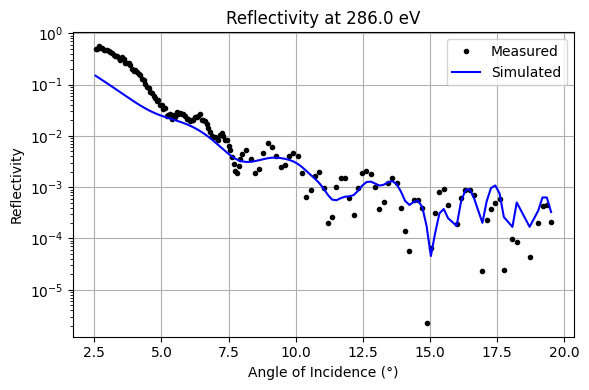

[np.float64(0.9971314479888994), np.float64(0.0021524197664215916), np.float64(0.9989575908502559), np.float64(0.003026412664110468)]
['n_resist_1_286.5', 'k_resist_1_286.5', 'n_resist_2_286.5', 'k_resist_2_286.5']


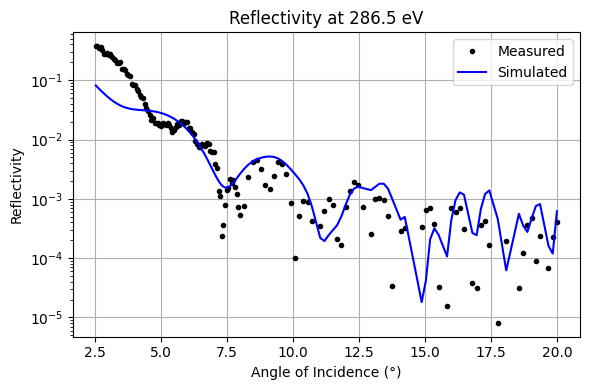

[np.float64(0.9970659525833387), np.float64(0.0021404933974750327), np.float64(0.9988285124224326), np.float64(0.0030095175817380078)]
['n_resist_1_287.0', 'k_resist_1_287.0', 'n_resist_2_287.0', 'k_resist_2_287.0']


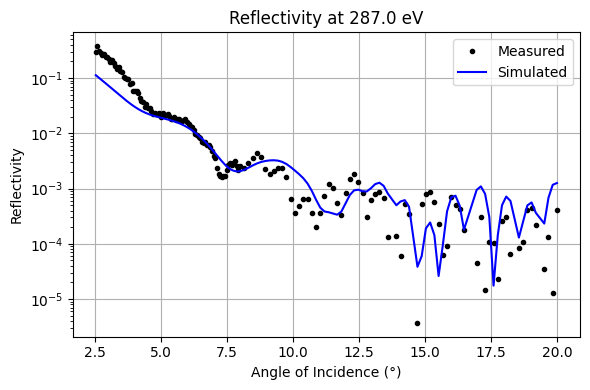

[np.float64(0.9969750590301905), np.float64(0.0021239206646732054), np.float64(0.9986493188536782), np.float64(0.0029860308278181133)]
['n_resist_1_287.7', 'k_resist_1_287.7', 'n_resist_2_287.7', 'k_resist_2_287.7']


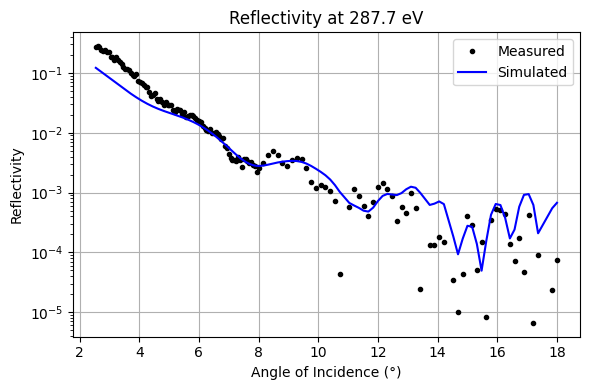

[np.float64(0.9968595403765128), np.float64(0.0021028117510938356), np.float64(0.998421497979098), np.float64(0.002956115846651465)]
['n_resist_1_288.6', 'k_resist_1_288.6', 'n_resist_2_288.6', 'k_resist_2_288.6']


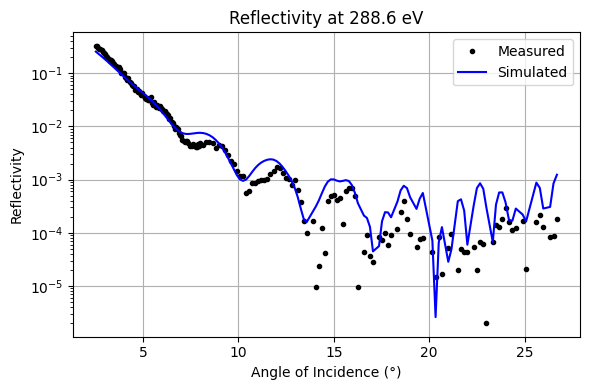

In [12]:
def objective_inner(x, aoi, xrr, sigma_sq, E, model, return_R=False):
    # Update model keys with current fit parameters
    for i, param in enumerate([p for p in model.domain_E_init if f'_{E}' in p['name']]):
        model.keys[param['name']] = x[i]

    # Build layer arrays for this energy
    layer, rough, n_stack = model.build_layer_arrays(E)

    # Simulate reflectivity
    wl = eVnm_converter(E)
    rm, tm = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=1)
    rm = np.square(np.abs(np.asarray(rm)))

    chi = np.sum(np.square(rm - xrr) / sigma_sq)
    return (chi, rm) if return_R else chi

def plot_reflectivity_comparison(aoi_rad, xrr, rm, E):
    aoi_deg = np.rad2deg(aoi_rad)

    plt.figure(figsize=(6, 4))
    plt.plot(aoi_deg, xrr, '.', label='Measured', color='black')
    plt.plot(aoi_deg, rm, '-', label='Simulated', color='blue')
    plt.xlabel('Angle of Incidence (°)')
    plt.ylabel('Reflectivity')
    plt.title(f'Reflectivity at {E:.1f} eV')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results = {}
for E in model.energy_points:
    xrr_all = combined_df[combined_df['E_round']==E] 
    #xrr_E = xrr_all[xrr_all['Energy'] == E]
    wl = eVnm_converter(E)
    aoi = np.deg2rad(xrr_all['Theta'].values) - np.deg2rad(model.keys['aoi_offset'])
    xrr = xrr_all['R'].values
    #print(xrr)
    sigma_sq = np.square(model.keys['a'] * xrr) + np.square(model.keys['b'])

    #layer, rough, n_stack = model.build_layer_arrays(E)

    # Extract initial guess and bounds

    x0 = [d['x0'] for d in model.domain_E_init if f'_{E}' in d['name']]
    print(x0)
    bounds = [d['domain'] for d in model.domain_E_init if f'_{E}' in d['name']]
    print([d['name'] for d in model.domain_E_init if f'_{E}' in d['name']])

    #for i, param in enumerate(model.domain_E_init):
    #    print(model.keys[param['name']])

    res = scipy.optimize.minimize(
        objective_inner, x0, bounds=bounds,
        args=(aoi, xrr, sigma_sq, E, model), method='TNC'
    )

    results[E] = res
    chi, rm = objective_inner(res.x, aoi, xrr, sigma_sq, E, model, return_R=True)
    plot_reflectivity_comparison(aoi, xrr, rm, E)


In [21]:
def objective_model_fit(x, model, combined_df, return_loglikelihood=False, return_all=False):
    # Split x into global and energy-dependent parts
    global_keys = [k for k, v in model.global_params.items() if v.get('fit')]
    n_global = len(global_keys)
    x_global = x[:n_global]
    x_energy = x[n_global:]

    # Update global parameters
    for i, key in enumerate(global_keys):
        model.keys[key] = x_global[i]

    # Initialize outputs
    chi_total = 0
    loglikelihood = 0

    if return_all:
        nk_E, R_E, R_exp_E, chi_E = [], [], [], []

    # Loop over energies
    for E in model.energy_points:
        # Update energy-dependent parameters
        energy_params = [p for p in model.domain_E_init if f'_{E}' in p['name']]
        for i, param in enumerate(energy_params):
            model.keys[param['name']] = x_energy[i]

        # Prepare data
        xrr_all = combined_df[combined_df['E_round'] == E]
        wl = eVnm_converter(E)
        aoi = np.deg2rad(xrr_all['Theta'].values) - np.deg2rad(model.keys['aoi_offset'])
        xrr = xrr_all['R'].values
        sigma_sq = np.square(model.keys['a'] * xrr) + np.square(model.keys['b'])

        # Build layer arrays
        layer, rough, n_stack = model.build_layer_arrays(E)

        # Simulate reflectivity
        rm, _ = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=1)
        rm = np.square(np.abs(np.asarray(rm)))

        # Compute chi²
        chi_E_val = np.sum(np.square(rm - xrr) / sigma_sq)
        chi_total += chi_E_val

        if return_loglikelihood:
            loglikelihood += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - chi_E_val / 2)

        if return_all:
            nk_E.append(x_energy)
            R_E.append(rm)
            R_exp_E.append(xrr)
            chi_E.append(chi_E_val)

    if return_loglikelihood:
        return loglikelihood
    if return_all:
        return np.asarray(nk_E), R_E, chi_E, chi_total

    return chi_total

def objective_model_fit_inner(x, model, combined_df, return_loglikelihood=False, return_all=False):
    # Split x into global and energy-dependent parts
    global_keys = [k for k, v in model.global_params.items() if v.get('fit')]
    n_global = len(global_keys)
    x_global = x#[:n_global]
    #x_energy = x[n_global:]

    # Update global parameters
    for i, key in enumerate(global_keys):
        model.keys[key] = x_global[i]

    # Initialize outputs
    chi_total = 0
    loglikelihood = 0

    if return_all:
        nk_E, R_E, R_exp_E, chi_E = [], [], [], []

    # Loop over energies
    for E in model.energy_points:
        # Update energy-dependent parameters
        energy_params = [p for p in model.domain_E_init if f'_{E}' in p['name']]
        #for i, param in enumerate(energy_params):
        #    model.keys[param['name']] = x_energy[i]

        # Prepare data
        xrr_all = combined_df[combined_df['E_round'] == E]
        #wl = eVnm_converter(E)
        aoi = np.deg2rad(xrr_all['Theta'].values) - np.deg2rad(model.keys['aoi_offset'])
        xrr = xrr_all['R'].values
        sigma_sq = np.square(model.keys['a'] * xrr) + np.square(model.keys['b'])

        x0 = [d['x0'] for d in model.domain_E_init if f'_{E}' in d['name']]
        bounds = [d['domain'] for d in model.domain_E_init if f'_{E}' in d['name']]

        res = scipy.optimize.minimize(
            objective_inner, x0, bounds=bounds,
            args=(aoi, xrr, sigma_sq, E, model), method='TNC'
        )

        chi_E_val, rm = objective_inner(res.x, aoi, xrr, sigma_sq, E, model, return_R=True)

        chi_total += chi_E_val

        if return_loglikelihood:
            loglikelihood += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - chi_E_val / 2)

        if return_all:
            nk_E.append(res.x)
            R_E.append(rm)
            R_exp_E.append(xrr)
            chi_E.append(chi_E_val)

    if return_loglikelihood:
        return loglikelihood
    if return_all:
        return np.asarray(nk_E), R_E, chi_E, chi_total

    return chi_total

def get_global_fit_params(global_params):
    x0 = []
    bounds = []
    keys = []

    for key, spec in global_params.items():
        if spec.get('fit', False):
            x0.append(spec['x0'])
            bounds.append(spec['bounds'])
            keys.append(key)

    return x0, bounds, keys


In [23]:
x0_global, bounds_global, global_keys = get_global_fit_params(model.global_params)
x0_energy = [d['x0'] for d in model.domain_E_init]
bounds_energy = [d['domain'] for d in model.domain_E_init]

x0 = x0_global #+ x0_energy
bounds = bounds_global #+ bounds_energy

res = differential_evolution(
    func=objective_model_fit_inner,
    bounds=bounds,
    args=(model, combined_df),
    strategy='best1bin',       # default strategy
    maxiter=1000,              # increase for deeper convergence
    popsize=15,                # population size multiplier
    tol=1e-6,                  # convergence tolerance
    mutation=(0.5, 1.0),       # mutation range
    recombination=0.7,         # crossover probability
    polish=True,               # refine with local search at the end
    disp=True,                  # print progress
    workers=39
)



/home/kas/Projects/.venv/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 973617.6021649239
differential_evolution step 2: f(x)= 587625.4873109714
differential_evolution step 3: f(x)= 587625.4873109714
differential_evolution step 4: f(x)= 587625.4873109714
differential_evolution step 5: f(x)= 587625.4873109714
differential_evolution step 6: f(x)= 587625.4873109714
differential_evolution step 7: f(x)= 587625.4873109714
differential_evolution step 8: f(x)= 587625.4873109714
differential_evolution step 9: f(x)= 587625.4873109714
differential_evolution step 10: f(x)= 587625.4873109714
differential_evolution step 11: f(x)= 559236.8492658811
differential_evolution step 12: f(x)= 559236.8492658811
differential_evolution step 13: f(x)= 559236.8492658811
differential_evolution step 14: f(x)= 559236.8492658811
differential_evolution step 15: f(x)= 482713.3202526587
differential_evolution step 16: f(x)= 482713.3202526587
differential_evolution step 17: f(x)= 482713.3202526587
differential_evolution step 18: f(x)= 400273.6076948531
d

In [16]:
res

 message: Converged (|x_n-x_(n-1)| ~= 0)
 success: True
  status: 2
     fun: 43438451.545383334
       x: [ 3.500e+01  9.000e-03 ...  9.984e-01  2.956e-03]
     nit: 1
     jac: [ 1.934e+14  9.822e+13 ... -0.000e+00  0.000e+00]
    nfev: 196

In [ ]:
ress

In [15]:
# Reconstruct keys
x_opt = res.x

# Get global keys
x0_global, bounds_global, global_keys = get_global_fit_params(model.global_params)
n_global = len(global_keys)

# Get energy-dependent keys
energy_keys = [d['name'] for d in model.domain_E_init]

# Combine all keys
all_keys = global_keys #+ energy_keys

# Print results
print("\n🔧 Fitted Parameters:")
for name, value in zip(all_keys, x_opt):
    print(f"{name} : {value:.6f}")




🔧 Fitted Parameters:
thickness_resist_1 : 35.000000
rough_resist_1 : 0.009000
thickness_resist_2 : 100.000000
rough_resist_2 : 0.009000


In [ ]:
class LayerSpec:
    def __init__(self, name):
        self.name = name
        self.params = {}

    def fit_thickness(self, x0, bounds):
        self.params['thickness'] = {'fit': True, 'x0': x0, 'bounds': bounds}
        return self

    def fixed_thickness(self, value):
        self.params['thickness'] = {'fit': False, 'value': value}
        return self

    def fit_roughness(self, x0, bounds):
        self.params['roughness'] = {'fit': True, 'x0': x0, 'bounds': bounds}
        return self

    def fixed_roughness(self, value):
        self.params['roughness'] = {'fit': False, 'value': value}
        return self

    def fit_nk_array(self, n_array, k_array, bounds_n, bounds_k):
        self.params['n'] = {
            'fit': True,
            'x0': n_array,
            'bounds': [bounds_n] * len(n_array)
        }
        self.params['k'] = {
            'fit': True,
            'x0': k_array,
            'bounds': [bounds_k] * len(k_array)
        }
        return self

    def fixed_nk(self, n_array, k_array):
        self.params['n'] = {'fit': False, 'value': n_array}
        self.params['k'] = {'fit': False, 'value': k_array}
        return self

#LayerSpec("resist_1")
#    .fit_thickness(35, bounds=(30, 45))
#    .fit_roughness(0.009, bounds=(0, 2))
#    .fit_nk_array(
#        n_array=[0.0038, 0.0039, 0.0040], 
#        k_array=[0.00086, 0.00088, 0.00090], 
#        bounds_n=(-0.05, 0.05), 
#        bounds_k=(0, 0.05)
#    )

def expand_energy_params(layer_stack, energy_uni):
    domain_E_init = []
    for layer in layer_stack:
        lname = layer.name
        for i, E in enumerate(energy_uni):
            if layer.params.get('n', {}).get('fit'):
                domain_E_init.append({
                    'name': f'n_{lname}_{E}',
                    'x0': layer.params['n']['x0'][i],
                    'domain': layer.params['n']['bounds'][i]
                })
            if layer.params.get('k', {}).get('fit'):
                domain_E_init.append({
                    'name': f'k_{lname}_{E}',
                    'x0': layer.params['k']['x0'][i],
                    'domain': layer.params['k']['bounds'][i]
                })
    return domain_E_init

def build_x0_dict(domain_E_init, energy_uni):
    x0_dict = {}
    for E in energy_uni:
        x0_dict[E] = [d['x0'] for d in domain_E_init if f'_{E}' in d['name']]
    return x0_dict

def build_layer_arrays(keys, layer_stack, E):
    layer = []
    rough = []
    n_stack = [1 + 0j]  # ambient

    for layer_spec in layer_stack:
        lname = layer_spec.name

        # Thickness
        if 'thickness' in layer_spec.params:
            if layer_spec.params['thickness']['fit']:
                layer.append(keys[f'thickness_{lname}'])
            else:
                layer.append(layer_spec.params['thickness']['value'])

        # Roughness
        if 'roughness' in layer_spec.params:
            if layer_spec.params['roughness']['fit']:
                rough.append(keys[f'rough_{lname}'])
            else:
                rough.append(layer_spec.params['roughness']['value'])

        # Optical constants
        if layer_spec.params['n']['fit']:
            n_real = keys[f'n_{lname}_{E}']
        else:
            n_real = layer_spec.params['n']['value'][E]

        if layer_spec.params['k']['fit']:
            n_imag = keys[f'k_{lname}_{E}']
        else:
            n_imag = layer_spec.params['k']['value'][E]

        n_stack.append(1 - n_real + n_imag * 1j)

    return np.array(layer), np.array(rough), np.array(n_stack)


def objective_inner(x, wl, aoi, xrr, sigma_sq, i, E, layer_stack, keys, return_R=False):
    # Update keys from fit parameters
    for ii in range(len(x)):
        keys[cols_inner[ii]] = x[ii]

    # Build layer arrays for this energy
    layer, rough, n_stack = build_layer_arrays(keys, layer_stack, E)

    # Calculate reflectivity
    rm, tm = mm.reflec_and_trans(n_stack, wl, aoi, layer, rough, pol=1)
    rm = np.square(np.abs(np.asarray(rm)))

    # Compute chi²
    chi = np.sum(np.square(rm - xrr) / sigma_sq)

    return (chi, rm) if return_R else chi

def objective_i(x, energy_uni, keys, layer_stack, return_loglikli=False, return_all=False):
    for ii in range(len(x)):
        keys[cols[ii]] = x[ii]

    x0 = keys['x0']
    chi = 0
    loglikli = 0

    if return_all:
        nk_E, R_E, R_exp_E, layer_E, rough_E, chi_E = [], [], [], [], [], []

    for i, E in enumerate(energy_uni):
        x_E = np.where(energy_uni == E)[0][0]
        xrr_all = keys['xrr_all'][keys['xrr_all']['Energy'] == E]

        wl = eVnm_converter(E)
        aoi = np.deg2rad(np.asarray(xrr_all['Theta'])) - np.deg2rad(keys['aoi_offset'])
        xrr = np.asarray(xrr_all['R'])
        sigma_sq = np.square(keys['a'] * xrr) + np.square(keys['b'])

        res = scipy.optimize.minimize(
            objective_inner, x0[E], bounds=bounds_inner,
            args=(wl, aoi, xrr, sigma_sq, i, E, layer_stack, keys), method='TNC'
        )
        x0[E] = res.x

        chi_temp = objective_inner(res.x, wl, aoi, xrr, sigma_sq, i, E, layer_stack, keys)
        chi += chi_temp

        if return_loglikli:
            loglikli += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - chi_temp / 2)

        if return_all:
            chi_temp, rm_temp = objective_inner(res.x, wl, aoi, xrr, sigma_sq, i, E, layer_stack, keys, return_R=True)
            nk_E.append(res.x)
            R_E.append(rm_temp)
            R_exp_E.append(xrr)
            layer_E.append(build_layer_arrays(keys, layer_stack, E)[0])
            rough_E.append(build_layer_arrays(keys, layer_stack, E)[1])
            chi_E.append(chi_temp)

    if return_loglikli:
        return loglikli
    if return_all:
        return np.asarray(nk_E), R_E, chi_E, chi

    return chi

In [9]:
domain_E_init = [
        {'name': 'n_1', 'x0': 0.0038448804394742, 'domain': (-5e-2,5e-2)},
        {'name': 'k_1', 'x0': 0.0008634292518711, 'domain': (0, 5e-2)},
        {'name': 'n_2', 'x0': 0.00273, 'domain': (-5e-2,5e-2)},
        {'name': 'k_2', 'x0': 0.000171, 'domain': (0, 5e-2)},
        #{'name': 'thickness_toxid', 'x0': 1.7763251456352267, 'domain': (0,2)},
        #{'name': 'thick_resist', 'x0': 30, 'domain': (19, 32)},
]
domain = [
        {'name': 'thick_resist_1', 'x0': 35, 'domain': (30, 45)},
        {'name': 'thick_resist_2', 'x0': 95, 'domain': (90, 105)},
        #{'name': 'thickness_toxid', 'x0': 1.5, 'domain': (0,2)},
        {'name': 'rough_resist_1', 'x0': 0.009469242182450963, 'domain': (0,2)},
        {'name': 'rough_resist_2', 'x0': 0.009469242182450963, 'domain': (0,2)},
        #{'name': 'rough_oxid', 'x0': 1.0202512063411806, 'domain': (0,1.5)},
        {'name': 'rough_substrate', 'x0': 0.01, 'domain': (0,2)},# 1.35},
        {'name': 'aoi_offset', 'x0': 0, 'domain': (-1,1)},        
        #{'name': 'a', 'x0': 0.04, 'domain': (0,0.05)},
        #{'name': 'b', 'x0': 2e-6, 'domain': (1e-11, 1e-4)},
        #{'name': 'darkcurrent', 'x0': 2e-6, 'domain': (0, 5e-4)},
        #{'name': 'n', 'x0': 0.02, 'domain': (-5e-3,5e-3)},
        #{'name': 'k', 'x0': 0.0015, 'domain': (0, 1e-2)},
        #{'name': 'stich_scale', 'x0': 1, 'domain': (0.1, 1.5)},
    ]
domain_E = []

for i in range(1, N_float + 1):
    domain.append({'name': f'thick_float_{i}', 'x0': 50, 'domain': (10, 100)})
    domain.append({'name': f'rough_float_{i}', 'x0': 0.01, 'domain': (0, 2)})
    domain_E_init.append({'name': f'n_float_{i}', 'x0': 0.01, 'domain': (-5e-2, 5e-2)})
    domain_E_init.append({'name': f'k_float_{i}', 'x0': 0.001, 'domain': (0, 5e-2)})

    
con_layer = True #Set to true if a contamtion layer should be added to the model.


if con_layer:
    domain.append({'name': 'thickness_c', 'x0': 1, 'domain': (0,2)})
    domain.append({'name': 'rough_c', 'x0': 0.1, 'domain': (0,3)})
    #domain_E_init.append({'name': 'density_c', 'x0': 1.8, 'domain': (0,5)})
    domain_E_init.append({'name': 'n_c', 'x0': 0.002, 'domain': (-5e-2,5e-2)})
    domain_E_init.append({'name': 'k_c', 'x0': 0.0015, 'domain': (0, 10e-2)})




#Make a list containg the name of the fi parameters
cols = [do['name'] for do in domain]
cols_inner = [do['name'] for do in domain_E_init]
##Define the upper and lower boundries by evaluating the domains
lb = [do['domain'][0] for do in domain]
ub = [do['domain'][1] for do in domain]
bounds = [do['domain'] for do in domain]
bounds_inner = [do['domain'] for do in domain_E_init]
x0_ = [do['x0'] for do in domain]

#for E in energy_uni:
#    for do in domain_E_init:#
#
#        lb.append(do['domain'][0])
#        ub.append(do['domain'][1]) #ub.append(do['domain'][1])
#        x0_.append(do['x0'])
#        bounds.append(do['domain'])
#        cols.append(do['name']+str(E))
        
        

lb = np.asarray(lb)
ub = np.asarray(ub)

#bounds_inner = [do['domain'] for do in domain_E]

#print(cols)

#Prepare a test vector for the objective function
x0_ = np.asarray(x0_)

#x0 = [np.mean(bound) for bound in bounds_inner]
#print(x0)

x_test = (lb+ub)/2 #[np.mean(bound) for bound in bounds]
print(x_test)
len_domain_E = len(domain_E)
len_domain = len(domain)

#This parameters can be kept constant to the values provided here.
keys = {
    'darkcurrent': 0,
    'a': 0.04529578438348669,
    'b': 2.5366001043504797e-5,
    'aoi_offset':0,
    'thickness_toxid':1.5,    
    'xrr_all' :combined_df,
    'E_uni': energy_uni,
    'stich_scale':1,
    'x0': [do['x0'] for do in domain_E_init]
}
#df = pd.read_csv('./DE_Escan_fix_to/'+sample_name+"fixto_results.csv")
#df = pd.read_csv('./DE_Escan/'+sample_name+"results.csv")
#for i, E in enumerate(keys['E_uni']):
#    try:
#        keys['x0' + str(E)] = [df[do['name'] + str(E)].values[0] for do in domain_E_init]
#    except:
#        keys['x0' + str(E)] = [do['x0'] for do in domain_E_init]
    

print(len(lb))
print(len(cols))

[37.5 97.5  1.   1.   1.   0.   1.   1.5]
8
8


In [8]:
# Here the objective funtion for the fit and the plot later one are defined, both the chi^2 and the logliklihood is calculated
def objective_inner(x, wl, aoi, layer, rough, xrr, sigma_sq, i, con_layer, return_R=False):
    """
    Calculates reflectivity and chi² for one energy value.

    Parameters:
    - x: array of fit parameters
    - wl: wavelength in nm
    - aoi: array of angle of incidence in radians
    - layer: array of layer thicknesses in nm
    - rough: array of layer roughnesses in nm
    - xrr: measured reflectivity
    - sigma_sq: squared uncertainties of reflectivity
    - i: index for nk_sub
    - con_layer: whether a contamination layer is included
    - return_R: if True, also return reflectivity curve
    """
    # Update keys from fit parameters
    for ii in range(len(x)):
        keys[cols_inner[ii]] = x[ii]

    # Start with ambient medium (air)
    n = [1 + 0j]

    # Add contamination layer if present
    if con_layer:
        n_c = 1 - keys['n_c'] + keys['k_c'] * 1j
        n.append(n_c)

    # Dynamically add all layers based on naming convention
    layer_count = len(layer)
    for idx in range(1, layer_count + 1):
        n_real = keys[f'n_{idx}']
        n_imag = keys[f'k_{idx}']
        n_complex = 1 - n_real + n_imag * 1j
        n.append(n_complex)

    # Add substrate
    n.append(nk_sub[i])
    n = np.array(n)

    # Calculate reflectivity
    rm, tm = mm.reflec_and_trans(n, wl, aoi, layer, rough, pol=1)
    rm = np.square(np.abs(np.asarray(rm)))

    # Compute chi²
    chi = np.sum(np.square(rm - xrr) / sigma_sq)

    return (chi, rm) if return_R else chi

def objective_i(x, return_loglikli=False, return_all=False, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer):
    for ii in range(len(x)):
        keys[cols[ii]] = x[ii]

    x0 = keys['x0']
    chi = 0
    loglikli = 0

    if return_all:
        nk_E, R_E, R_exp_E, layer_E, rough_E, chi_E = [], [], [], [], [], []

    layer = []
    rough = []

    if con_layer:
        layer.append(keys['thickness_c'])
        rough.append(keys['rough_c'])

    # Dynamically collect resist layers
    layer_idx = 1
    while f'thick_resist_{layer_idx}' in keys and f'rough_resist_{layer_idx}' in keys:
        layer.append(keys[f'thick_resist_{layer_idx}'])
        rough.append(keys[f'rough_resist_{layer_idx}'])
        layer_idx += 1

    # Add oxide and substrate layers
    layer.append(keys['thickness_toxid'])
    rough.append(keys['rough_substrate'])
    rough.append(keys['rough_substrate'])  # repeated substrate roughness

    layer = np.array(layer)
    rough = np.array(rough)

    for i, E in enumerate(keys['E_uni']):
        x_E = np.where(energy_uni == E)[0][0]
        xrr_all = keys['xrr_all'][keys['xrr_all']['Energy'] == E]

        wl = eVnm_converter(E)
        aoi = np.deg2rad(np.asarray(xrr_all['Theta'])) - np.deg2rad(keys['aoi_offset'])
        xrr = np.asarray(xrr_all['R'])
        sigma_sq = np.square(keys['a'] * xrr) + np.square(keys['b'])


        res = scipy.optimize.minimize(
            objective_inner, x0, bounds=bounds_inner,
            args=(wl, aoi, layer, rough, xrr, sigma_sq, i, con_layer), method='TNC'
        )
        x0 = res.x

        chi_temp = objective_inner(res.x, wl, aoi, layer, rough, xrr, sigma_sq, i, con_layer)
        chi += chi_temp

        if return_loglikli:
            loglikli += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - chi_temp / 2)

        if return_all:
            nk_E.append(res.x)
            chi_temp, rm_temp = objective_inner(res.x, wl, aoi, layer, rough, xrr, sigma_sq, i, con_layer, return_R=True)
            R_E.append(rm_temp)
            chi_E.append(chi_temp)
            R_exp_E.append(xrr)
            layer_E.append(layer)
            rough_E.append(rough)

    if return_loglikli:
        return loglikli
    if return_all:
        return np.asarray(nk_E), R_E, chi_E, chi

    return chi

def objective_plot(keys,return_loglikli=False, return_all=False, con_layer=
                   , optical_constanst_oxide_layer=optical_constanst_oxide_layer):
    """
    In the function all the fit parameters are optimized.
    x: array containg the fit parameters that are optimzed.
    return_all: Turn to True if the calculated refelctivity and nk should be returned for a given x values
    con_layer: True or False depending if a conatamintion layer is part of the model
    """


    #x0 can be a global defined starting point for the inner optimzation
    #global x0
    #x0 = [np.mean(bound) for bound in bounds_inner]

    #intialize chi
    chi = 0
    loglikli = 0

    #define the parameters for the model: layer thickness and roughness
    
        #layer_thickness = np.array([])#keys['thick_resist']*keys['procent_resist'],keys['thick_resist']*(1-keys['procent_resist'])])
    

    #print(layer)
    #prepare the arrays that will be returned
    if return_all:
        nk_E = []
        R_E = []
        R_exp_E = []
        layer_E = []
        rough_E = []
        #chi_E = []

    if con_layer:
        layer = np.array([keys['thickness_c']])
        rough = np.array([keys['rough_c']])
    else:
        layer = np.array([])
        rough = np.array([])


        
    rough = np.append(rough,keys['rough_resist_1'])
    rough = np.append(rough,keys['rough_resist_2'])
    layer = np.append(layer,keys['thick_resist_1'])
    layer = np.append(layer,keys['thick_resist_2'])
    layer = np.append(layer,keys['thickness_toxid'])
    rough = np.append(rough,keys['rough_substrate'])
    rough = np.append(rough,keys['rough_substrate'])

    
    
    #Iteration over the different wavelength and the corresponding inner fit
    for i,E in enumerate(keys['E_uni']):
        x_E = np.where(energy_uni==E)[0][0]
        xrr_all = keys['xrr_all'][keys['xrr_all']['Energy']==E]      


        wl = eVnm_converter(E)

        aoi = np.deg2rad(np.asarray(xrr_all['Theta'])) - np.deg2rad(keys['aoi_offset'])
        xrr = np.asarray(xrr_all['R'])
        #print(xrr)
        #sigma_sq = np.square(xrr_all['δr [a. u.]']) #SIGMA_sq[xx] δI [arb. un.]
        sigma_sq = np.square(keys['a'] * xrr) + np.square(keys['b'])
        #sigma_sq = np.abs(xrr)
        
        if optical_constanst_oxide_layer == False:
            keys['n_o'] = 1-np.real(nk_sub_oxid[x_E])
            keys['k_o'] = np.imag(nk_sub_oxid[x_E])
        else:
            keys['n_o'] = keys['n_o']
            keys['k_o'] = keys['k_o']
            #print(keys['n_o'])
    
        n = np.array([1 + 0 * 1j])
        if con_layer:
            #n = np.append(n,1 - keys['n_1'+str(E)] + keys['k_1'+str(E)]*np.abs(keys['density_c'+str(E)]) * 1j)
            n = np.append(n,1 - keys['n_c'+str(E)] + keys['k_c'+str(E)] * 1j)
        n = np.append(n,1 - keys['n_1'+str(E)] + keys['k_1'+str(E)] * 1j)
        n = np.append(n,1 - keys['n_2'+str(E)] + keys['k_2'+str(E)] * 1j)
        n = np.append(n,1 - keys['n_o'] + keys['k_o'] * 1j)
        n = np.append(n,nk_sub[x_E])

        rm, tm = mm.reflec_and_trans(n, wl, aoi, layer, rough, pol=1)  # polarization (either 1 for s-polarization or 0 for p-polarization)
        rm = np.square(np.abs(np.asarray(rm)))
        #chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))

        rm = rm +keys['darkcurrent']
        loglikli += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))
        chi += np.sum(np.square(rm - xrr) / (sigma_sq))
        
        #chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))

        #print('here innner finished')
        if return_all:
            nk_E.append(n)
            #chi_temp, rm_temp = objective_inner(res.x, wl, aoi, layer, rough, xrr, sigma_sq, i, return_R=True)
            R_E.append(rm)
            R_exp_E.append(xrr)
            layer_E.append(layer)
            rough_E.append(rough)

        # chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq))) - chi_inner/2

    if return_all:
        return (nk_E), (R_E), chi
    if return_loglikli:
        return loglikli
    
    return chi

objective_i(x_test)


NameError: name 'con_layer' is not defined

In [26]:
#Use scipy DE to run the fit, depending on the convergence the fit should take between 8 min to 25 min for a two layer model

#df = pd.read_csv('./DE_Escan_fix_to/'+'SOG3'+"fixto_results.csv")
#df = pd.read_csv('./DE_Escan/'+sample_name+"results.csv")
#x0_ = []
# Iterate through columns
#for column in df.columns:
#    keys[column] = float(df[column].values[0])
#   x0_.append(float(df[column].values[0])) 
#print(x0_)

result = differential_evolution(objective_i, bounds,x0=x0_,workers=-1)
print(result)


/home/kas/Projects/.venv/lib/python3.12/site-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [19]:
#Print the results including the optical cosntants
x = result.x
#x[-1] = np.abs(x[-1])
nk_E, R_E, chi_E, chi = objective_i(x, return_all = True, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer)
print(chi)
print(nk_E[0])
print(len(result.x))
for j,col in enumerate(cols):
    print(col,': ',result.x[j])

for j,E in enumerate(energy_uni):
    for i,do in enumerate(domain_E_init):#
        col = do['name']+str(E)
        print(col,': ',nk_E[j][i])


70564.66455678853
[0.00405995 0.00090876 0.00211719 0.        ]
6
thick_resist_1 :  35.80620936279067
thick_resist_2 :  100.5265128720544
rough_resist_1 :  0.02563158987311409
rough_resist_2 :  0.19689555729816222
rough_substrate :  0.043903561199399865
aoi_offset :  0.00665547795934085
n_1250.0 :  0.004059954116526393
k_1250.0 :  0.0009087614626948348
n_2250.0 :  0.002117185838985935
k_2250.0 :  0.0
n_1284.0 :  0.0019250353449989308
k_1284.0 :  0.0007549719142039939
n_2284.0 :  -0.00024863173772009814
k_2284.0 :  0.00010614983161550892
n_1284.2 :  0.0018502460860923805
k_1284.2 :  0.0007930774947035625
n_2284.2 :  -0.0004256513099318167
k_2284.2 :  0.00011055946403501493
n_1284.6 :  0.0017552082770754204
k_1284.6 :  0.000995231407843189
n_2284.6 :  -0.001024598263836687
k_2284.6 :  0.0001865938651780738
n_1285.0 :  0.001811075455955704
k_1285.0 :  0.0018534887728702473
n_2285.0 :  -0.0016903934493759324
k_2285.0 :  0.0015387995909899588
n_1285.5 :  0.0024047669123801216
k_1285.5 :  0.

In [77]:
nk_E

array([[ 3.20867469e-03,  9.82428905e-04,  3.06973311e-03,
         1.08519501e-03,  2.45051968e-03,  2.61126883e-04],
       [ 1.12114677e-03,  1.11045569e-03,  1.40141498e-03,
         7.51349592e-04, -4.75262390e-05,  2.06792306e-04],
       [ 9.89256726e-04,  1.25928128e-03,  1.25381083e-03,
         6.89343663e-04, -1.98254158e-04,  2.62332972e-04],
       [-1.30664397e-04,  9.77442594e-04,  1.41666595e-03,
         2.02592840e-03, -4.50528872e-04,  0.00000000e+00],
       [ 1.75209350e-03,  3.57257413e-03,  3.17001925e-04,
         2.85765838e-03, -1.95907514e-03,  2.60766425e-03],
       [ 2.49370664e-03,  1.57622077e-03,  2.60308638e-03,
         1.63911580e-03,  1.17050572e-03,  1.86416880e-03],
       [ 1.83029750e-03,  8.13225050e-04,  2.12415974e-03,
         9.95309976e-04,  7.01796853e-04,  4.62112861e-04],
       [ 1.33212524e-03,  7.37027199e-04,  1.63072413e-03,
         9.96538275e-04, -5.18885537e-05,  2.49262326e-04],
       [-3.61243081e-04,  0.00000000e+00,  2.175

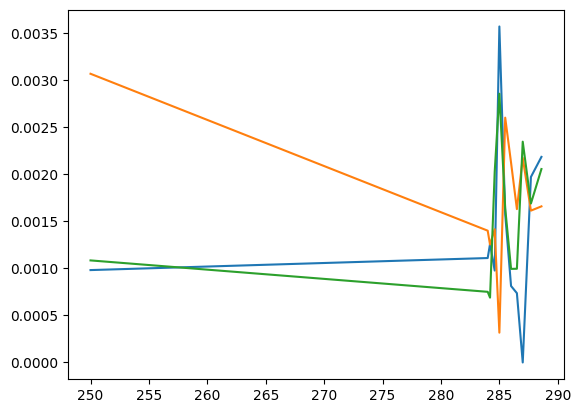

In [78]:
plt.plot(energy_uni,np.asarray(nk_E)[:,1])
plt.plot(energy_uni,np.asarray(nk_E)[:,2])
plt.plot(energy_uni,np.asarray(nk_E)[:,3])

In [20]:
# Initialize an empty dictionary for storing data
data = {}

# First loop: store result.x values
for j, col in enumerate(cols):
    data[col] = [result.x[j]]

# Second loop: store nk_E values
for j, E in enumerate(energy_uni):
    for i, do in enumerate(domain_E_init):
        col = do['name'] + str(E)
        data[col] = [nk_E[j][i]]

# Convert dictionary into a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)
df.to_csv('./DE_Escan_fix_to/'+sample_name+"fixto_results.csv", index=False)
#df.to_csv('./DE_Escan_fix_to/'+sample_name+"fixto_c_results.csv", index=False)
#df.to_csv('./DE_Escan/'+sample_name+"results.csv", index=False)


   thick_resist_1  thick_resist_2  rough_resist_1  rough_resist_2  \
0       35.806209      100.526513        0.025632        0.196896   

   rough_substrate  aoi_offset  n_1250.0  k_1250.0  n_2250.0  k_2250.0  ...  \
0         0.043904    0.006655   0.00406  0.000909  0.002117       0.0  ...   

   n_2287.0  k_2287.0  n_1287.7  k_1287.7  n_2287.7  k_2287.7  n_1288.6  \
0 -0.000068  0.000635  0.002186  0.002624 -0.000429  0.000256   0.00251   

   k_1288.6  n_2288.6  k_2288.6  
0  0.002069 -0.001704  0.002249  

[1 rows x 50 columns]


In [21]:
#Save the data to be used to be plotted in plotly  dash
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plot_data = []  # List to collect data for all plots
df = pd.read_csv('./DE_Escan_fix_to/'+sample_name+"fixto_results.csv")
#df = pd.read_csv('./DE_Escan_fix_to/'+sample_name+"fixto_c_results.csv")
#df = pd.read_csv('./DE_Escan/'+sample_name+"results.csv")

# Iterate through columns
for column in df.columns:
    keys[column] = df[column].values[0]

nk_E, R_E, chi = objective_plot(keys, return_all = True, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer)
for i,E in enumerate(keys['E_uni']):
    xrr_all = keys['xrr_all'][keys['xrr_all']['Energy'] == E]
    absolute_error = np.sqrt(np.square(keys['a'] * xrr_all['R']) + np.square(keys['b'] )) #* xrr_all['theta']
    #plt.plot(xrr_all['Theta'],xrr_all['R'])
    #plt.plot(xrr_all['Theta'],R_E[i].T)
    #plt.yscale('log')
    #plt.show()
    # Collect data for the current plot
    print(E)
    plot_data.append({
        'file_name': sample_name,
        'energy': E,
        'theta': list(xrr_all['Theta']),
        'reflectivity_exp': list(xrr_all['R']),
        'reflectivity_model': list(R_E[i].T),
        'absolute_error': list(absolute_error),
        'residuals': list(np.square(xrr_all['R'] - R_E[i].T) / np.square(absolute_error)),
        'chi': chi
    })



# Convert plot_data into a DataFrame
df_plot_data = pd.DataFrame(plot_data)

# Save the DataFrame to a CSV file
df_plot_data.to_csv('./DE_Escan_fix_to/'+sample_name+"_fixto_plot.csv", index=False)
#df_plot_data.to_csv('./DE_Escan_fix_to/'+sample_name+"_fixto_c_plot.csv", index=False)
#df_plot_data.to_csv('./DE_Escan/'+sample_name+"_plot.csv", index=False)

# Display the DataFrame
#df_plot_data.plot('theta','reflectivity_exp')

250.0
284.0
284.2
284.6
285.0
285.5
286.0
286.5
287.0
287.7
288.6


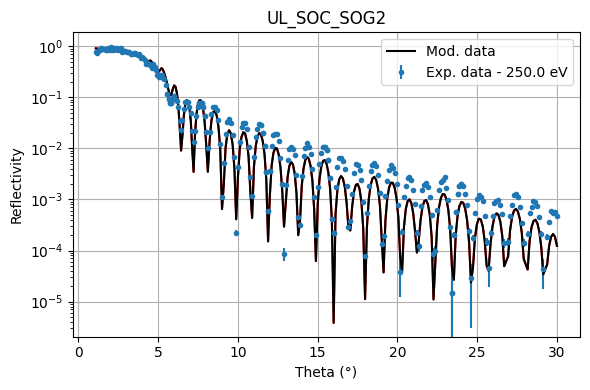

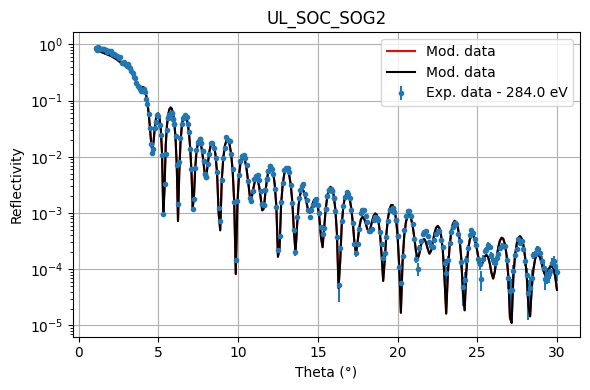

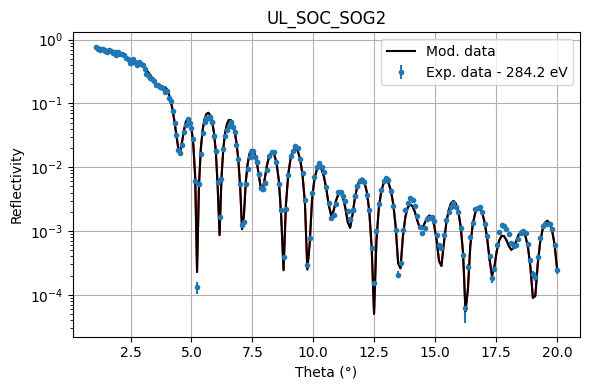

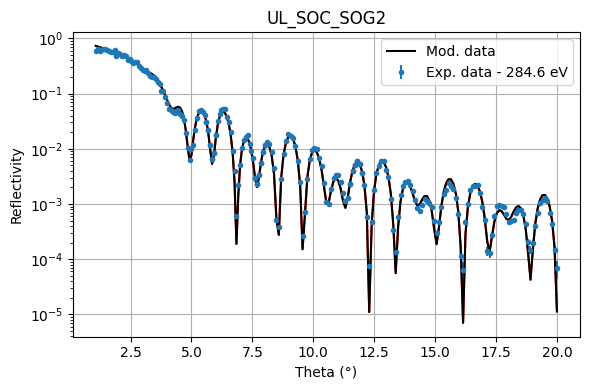

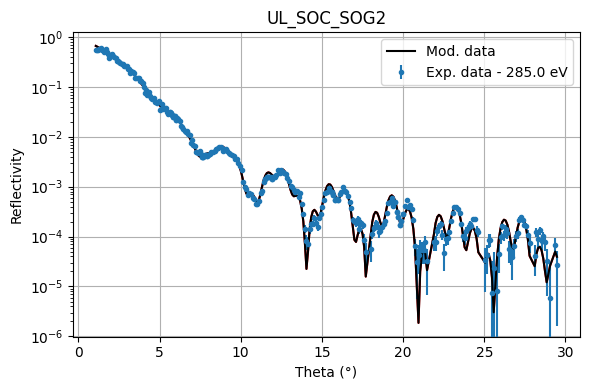

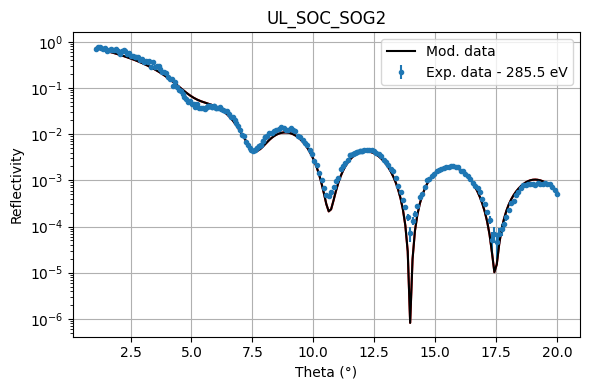

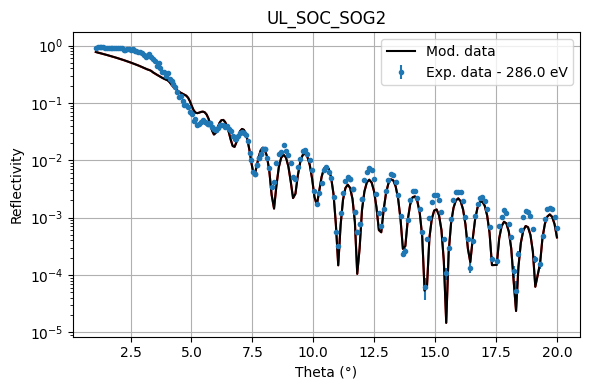

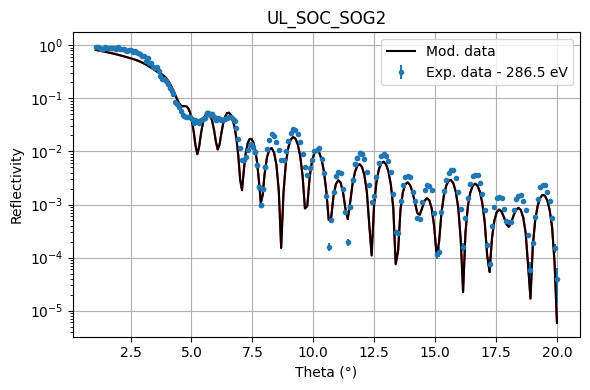

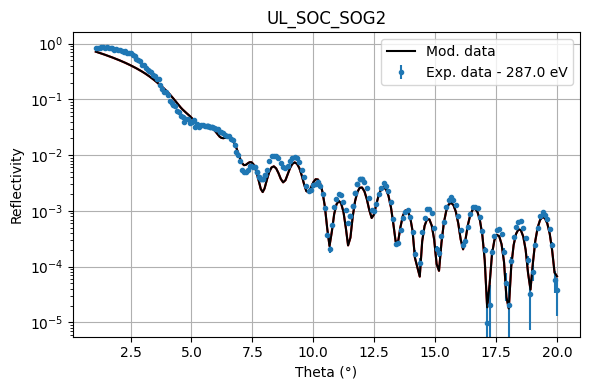

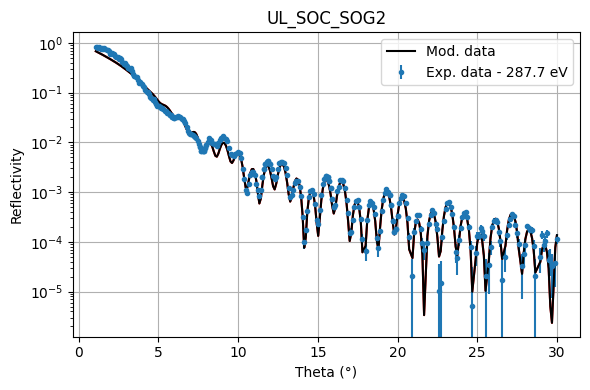

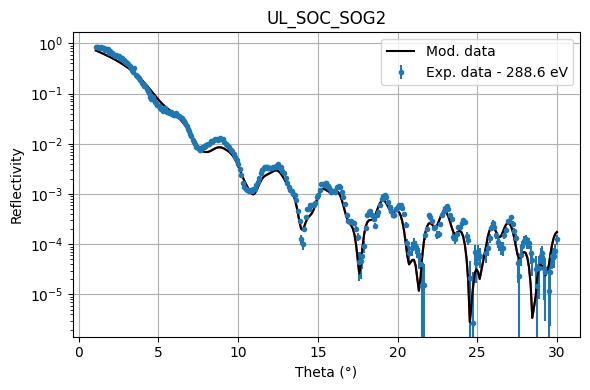

In [22]:
#Some plotting to check the result of the fit
import matplotlib.pyplot as plt

# Define the update_graph function
def update_graph(keys, R_E, df = None):
    max_i = len(keys['E_uni'])
    
    
    
    # Main graph
    for i,E in enumerate(keys['E_uni']):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        xrr_all = keys['xrr_all'][keys['xrr_all']['Energy'] == E]
        name = str(E)

        if df is not None:
            df_subset = df[df["energy"]==E]
            if i == 1:
                ax1.plot(df_subset['theta'], df_subset['reflectivity_model'], '-',color='red', label='Mod. data')
            else:
                ax1.plot(df_subset['theta'], df_subset['reflectivity_model'], '-',color='red')

        # Plot experimental and fitted data
        # Calculate absolute error
        absolute_error = np.sqrt(np.square(keys['a'] * xrr_all['R']) + np.square(keys['b'] )) #* xrr_all['theta']
        
        # Plot experimental data with error bars
        ax1.errorbar(xrr_all['Theta'], xrr_all['R'], yerr=absolute_error, fmt='.', label='Exp. data - ' + name + ' eV')
        
        #ax1.plot(xrr_all['Theta'], xrr_all['R'], '.', label='Exp. data - '+str(E)+' eV')
        if i == 1:
            ax1.plot(xrr_all['Theta'], R_E[i].T, '-',color='black', label='Mod. data')
        else:
            ax1.plot(xrr_all['Theta'], R_E[i].T, '-',color='black')
    
        ax1.set_yscale('log')
        ax1.set_ylabel('Reflectivity')
        ax1.set_title('Exposed Resist - homogeneous')
        ax1.legend()
        ax1.grid(True)
        
        # Residuals plot

        residuals = np.square(xrr_all['R'] - R_E[i].T)/np.square(absolute_error) #np.square(rm - xrr) / (sigma_sq)
        ax2.plot(xrr_all['Theta'], residuals, '.-', label='Residuals - '+name+' eV')
        
        ax2.set_xlabel('Theta (°)')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residuals Plot')
        #ax2.set_yscale('log')
        #ax2.set_ylim(-0.25,0.25)
        ax2.legend(loc='center right')#, bbox_to_anchor=(1, 0.5))
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


# Define the update_graph function
def update_graph_no_res(keys, R_E,df=None,save=False):
    max_i = len(keys['E_uni'])
    
    
    
    # Main graph
    for i,E in enumerate(keys['E_uni']):
        fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
        xrr_all = keys['xrr_all'][keys['xrr_all']['Energy'] == E]
        name = str(E)

        if df is not None:
            df_subset = df[df["energy"] == E]
            theta = eval(df_subset['theta'].values[0])
            reflectivity_model = eval(df_subset['reflectivity_model'].values[0])
            if i == 1:
                ax1.plot(theta, reflectivity_model, '-',color='red', label='Mod. data')
            else:
                ax1.plot(theta, reflectivity_model, '-',color='red')
        # Plot experimental and fitted data
        # Calculate absolute error
        absolute_error = np.sqrt(np.square(keys['a'] * xrr_all['R']) + np.square(keys['b'] )) #* xrr_all['theta']
        
        # Plot experimental data with error bars
        ax1.errorbar(xrr_all['Theta'], xrr_all['R'], yerr=absolute_error, fmt='.', label='Exp. data - ' + name + ' eV')
        
        #ax1.plot(xrr_all['Theta'], xrr_all['R'], '.', label='Exp. data - '+str(E)+' eV')
        ax1.plot(xrr_all['Theta'], R_E[i].T, '-',color='black', label='Mod. data')
    
        ax1.set_yscale('log')
        ax1.set_ylabel('Reflectivity')
        ax1.set_title(sample_name)
        ax1.legend()
        ax1.grid(True)
        ax1.set_xlabel('Theta (°)')
    
        
        plt.tight_layout()
        if save:
            fig.savefig('./high_res_plot/'+sample_name+str(E)+'.png',dpi=300)
        plt.show()

# Example usage
#df = pd.read_csv('./DE_Escan/'+sample_name+"_plot.csv")
df = pd.read_csv('./DE_Escan_fix_to/'+sample_name+"_fixto_plot.csv")
#print(df)
update_graph_no_res(keys, R_E,df=df,save=False)


In [53]:
sample_name

'TOK_exps_UL_SOG2'

In [83]:
data 
df_data = pd.read_csv('./DE_Escan_fix_to/'+sample_name+"fixto_results.csv")
df_data.columns
data.keys()


dict_keys(['thick_resist_1', 'thick_resist_2', 'rough_resist_1', 'rough_resist_2', 'rough_substrate', 'aoi_offset', 'thickness_c', 'rough_c', 'n_1250.0', 'k_1250.0', 'n_2250.0', 'k_2250.0', 'n_c250.0', 'k_c250.0', 'n_1284.0', 'k_1284.0', 'n_2284.0', 'k_2284.0', 'n_c284.0', 'k_c284.0', 'n_1284.2', 'k_1284.2', 'n_2284.2', 'k_2284.2', 'n_c284.2', 'k_c284.2', 'n_1284.6', 'k_1284.6', 'n_2284.6', 'k_2284.6', 'n_c284.6', 'k_c284.6', 'n_1285.0', 'k_1285.0', 'n_2285.0', 'k_2285.0', 'n_c285.0', 'k_c285.0', 'n_1285.5', 'k_1285.5', 'n_2285.5', 'k_2285.5', 'n_c285.5', 'k_c285.5', 'n_1286.0', 'k_1286.0', 'n_2286.0', 'k_2286.0', 'n_c286.0', 'k_c286.0', 'n_1286.5', 'k_1286.5', 'n_2286.5', 'k_2286.5', 'n_c286.5', 'k_c286.5', 'n_1287.0', 'k_1287.0', 'n_2287.0', 'k_2287.0', 'n_c287.0', 'k_c287.0', 'n_1287.7', 'k_1287.7', 'n_2287.7', 'k_2287.7', 'n_c287.7', 'k_c287.7', 'n_1288.6', 'k_1288.6', 'n_2288.6', 'k_2288.6', 'n_c288.6', 'k_c288.6'])

In [84]:
import pandas as pd
import plotly.express as px

# Filter columns that start with 'n_1'
n_1_cols = [col for col in df_data.columns if col.startswith('n_1')]
n_2_cols = [col for col in df_data.columns if col.startswith('n_2')]
n_c_cols = [col for col in data.keys() if col.startswith('n_c')]

# Extract wavelength values from the column names
wavelengths = [float(col.replace('n_1','')) for col in n_1_cols]
print(wavelengths)

# Second set
dfc = pd.DataFrame({
    'Wavelength': [float(col.replace('n_c','')) for col in n_c_cols],
    #'Original': df_data[n_c_cols].iloc[0],
    'New': [data[col][0] for col in n_c_cols]
}).melt(id_vars='Wavelength', var_name='Source', value_name='n_value')
dfc['Dataset'] = 'top'

# First set
df1 = pd.DataFrame({
    'Wavelength': [float(col.replace('n_1','')) for col in n_1_cols],
    'Original': df_data[n_1_cols].iloc[0],
    'New': [data[col][0] for col in n_1_cols]
}).melt(id_vars='Wavelength', var_name='Source', value_name='n_value')
df1['Dataset'] = 'Resist'

# Second set
df2 = pd.DataFrame({
    'Wavelength': [float(col.replace('n_2','')) for col in n_2_cols],
    'Original': df_data[n_2_cols].iloc[0],
    'New': [data[col][0] for col in n_2_cols]
}).melt(id_vars='Wavelength', var_name='Source', value_name='n_value')
df2['Dataset'] = 'UL'

# Combine
# Instead of separate 'Source' and 'Dataset', create a unified label
for df, label in zip([dfc, df1, df2], ['top', 'Resist', 'UL']):
    df['Curve'] = df['Source'] + f' ({label})'
plot_df_long = pd.concat([dfc, df1, df2])


# Plot
fig = px.line(plot_df_long, x='Wavelength', y='n_value', color='Curve',
              title='Refractive Index Comparison', markers=True)
fig.show()


[250.0, 284.0, 284.2, 284.6, 285.0, 285.5, 286.0, 286.5, 287.0, 287.7, 288.6]


In [71]:
n_c_cols

[]

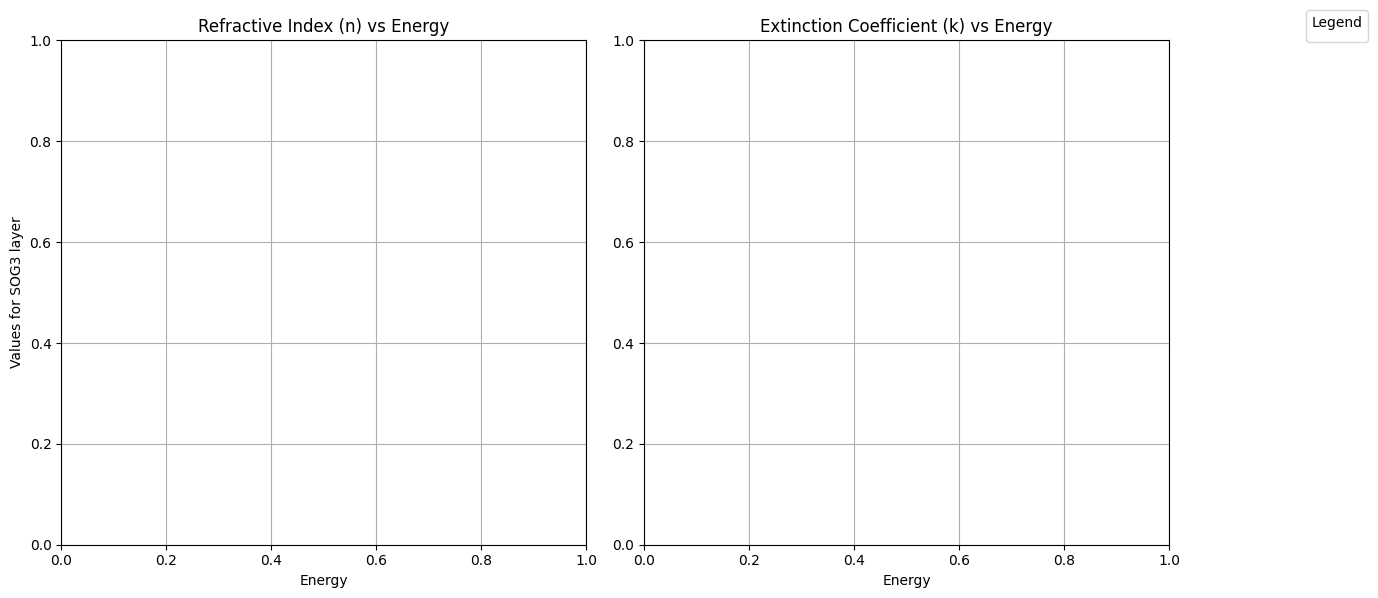

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Select relevant columns
n_columns = [col for col in df_data.columns if col.startswith('n_1') and not col.startswith('n_c')]
k_columns = [col for col in df_data.columns if col.startswith('k_1') and not col.startswith('k_c')]

# Extract energy values from column names
energy_values_n = [float(col[-5:]) for col in n_columns]
energy_values_k = [float(col[-5:]) for col in k_columns]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

legend_labels = []  # To store legend labels
legend_handles = []  # To store legend color handles

# Plot 'n_' columns
for col, energy in zip(n_columns, energy_values_n):
    if not subset.empty:
        scatter = ax1.scatter(np.full_like(df_data[col], energy), df_data[col], color='blue', alpha=0.7)
        ax1.plot(np.full_like(df_data[col], energy), df_data[col], color='blue', alpha=0.7)
        
        label = f"no c layer"
        if label not in legend_labels:
            legend_labels.append(label)
            legend_handles.append(scatter)


ax1.set_xlabel("Energy")
ax1.set_ylabel("Values for SOG3 layer")
ax1.set_title("Refractive Index (n) vs Energy")
#ax1.set_xlim(283, 290)
ax1.grid()

# Plot 'k_' columns
for col, energy in zip(k_columns, energy_values_k):
    if not subset.empty:
        scatter = ax2.scatter(np.full_like(df_data[col], energy), subset[col], color='blue', alpha=0.7)


ax2.set_xlabel("Energy")
ax2.set_title("Extinction Coefficient (k) vs Energy")
#ax2.set_xlim(283, 290)
ax2.grid()

# Add a single legend for both plots (only include plotted entries)
fig.legend(legend_handles, legend_labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Legend")

plt.tight_layout()
plt.show()

In [27]:
np.asarray(df[df['energy']==250]['theta'][0])

array('[2.2, 2.4400000000000004, 2.6799999999999997, 2.92, 3.16, 3.4000000000000004, 3.6399999999999997, 3.88, 4.12, 4.359999999999999, 4.6, 4.84, 5.08, 5.319999999999999, 5.56, 5.8, 6.04, 6.279999999999999, 6.279999999999999, 6.52, 6.52, 6.76, 6.76, 7.0, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.25, 9.5, 9.5, 9.75, 9.75, 10.0, 10.0, 10.624, 11.25, 11.876000000000001, 12.5, 13.124, 13.124, 13.75, 13.75, 14.374, 14.374, 15.676, 16.352, 17.028, 17.701999999999998, 18.378, 19.054, 19.73, 20.406, 21.081999999999997, 21.756, 22.432, 23.108, 23.784, 24.459999999999997, 25.136, 25.81, 26.485999999999997, 27.162, 27.837999999999997, 28.514, 29.189999999999998, 29.863999999999997, 30.54, 31.215999999999998, 31.892, 32.568, 33.244, 33.918, 34.594, 35.269999999999996, 35.946, 36.622, 37.298, 37.972, 38.647999999999996, 39.324, 40.0]',
      dtype='<U841')

### Do MCMC with DE inner fit as starting
Here ther results from the DE are used as a starting parameter and the error model a*Refelctivity +b is added. The strucutre is similiar to the last chapter

In [26]:
domain_E_init = [
        {'name': 'n_1', 'x0': 0.00273, 'domain': (-5e-2,5e-2)},
        {'name': 'k_1', 'x0': 0.000171, 'domain': (0, 10e-2)},
        #{'name': 'n_2', 'x0': 0.00273, 'domain': (-5e-2,5e-2)},
        #{'name': 'k_2', 'x0': 0.000171, 'domain': (0, 1e-2)},
        
        #{'name': 'thickness_toxid', 'x0': 1.7763251456352267, 'domain': (0,2)},
        #{'name': 'thick_resist', 'x0': 30, 'domain': (19, 32)},
]
domain = [
        {'name': 'thick_resist_1', 'x0': 35.6, 'domain': (15, 40)},
        #{'name': 'thick_resist_2', 'x0': 35, 'domain': (30, 45)},
        {'name': 'thickness_toxid', 'x0': 1.5, 'domain': (0,2)},
        {'name': 'rough_resist_1', 'x0': 0.009469242182450963, 'domain': (0,2)},
        #{'name': 'rough_resist_2', 'x0': 0.009469242182450963, 'domain': (0,10)},
        #{'name': 'rough_oxid', 'x0': 1.0202512063411806, 'domain': (0,1.5)},
        {'name': 'rough_substrate', 'x0': 0.01, 'domain': (0,1)},# 1.35},
        {'name': 'aoi_offset', 'x0': 0, 'domain': (-1,1)},        
        {'name': 'a', 'x0': 0.04, 'domain': (0,0.05)},
        {'name': 'b', 'x0': 2e-6, 'domain': (1e-11, 1e-5)},
        #{'name': 'darkcurrent', 'x0': 2e-6, 'domain': (0, 5e-4)},
        #{'name': 'n', 'x0': 0.02, 'domain': (-5e-3,5e-3)},
        #{'name': 'k', 'x0': 0.0015, 'domain': (0, 1e-2)},
        #{'name': 'stich_scale', 'x0': 1, 'domain': (0.1, 1.5)},
    ]
domain_E = []

    
con_layer = True #Set to true if a contamtion layer should be added to the model.
divergenz = False #For later if diverenz need to added.
optical_constanst_oxide_layer = False #The substrate can have a native oxide layer. If the nk of this layer should be modeled set it to True otherwise database values need to be provided.
if optical_constanst_oxide_layer:
    domain.append({'name': 'n_o', 'x0':  0.02, 'domain': (0,1e-2)})
    domain.append({'name': 'k_o', 'x0': 0.0015, 'domain': (0, 1e-2)})
if con_layer:
    domain.append({'name': 'thickness_c', 'x0': 1, 'domain': (0.1,10)})
    domain.append({'name': 'rough_c', 'x0': 0.1, 'domain': (0,3)})
    #domain_E_init.append({'name': 'density_c', 'x0': 1.8, 'domain': (0,5)})
    domain_E_init.append({'name': 'n_c', 'x0': 0.002, 'domain': (-1e-2,1e-2)})
    domain_E_init.append({'name': 'k_c', 'x0': 0.0015, 'domain': (0, 10e-2)})
if divergenz:
    domain.append({'name': 'divergenz', 'x0': 1e-5, 'domain': (0,0.1)})



#Make a list containg the name of the fi parameters
cols = [do['name'] for do in domain]
cols_inner = [do['name'] for do in domain_E_init]
##Define the upper and lower boundries by evaluating the domains
lb = [do['domain'][0] for do in domain]
ub = [do['domain'][1] for do in domain]
bounds = [do['domain'] for do in domain]
bounds_inner = [do['domain'] for do in domain_E_init]
x0_ = [do['x0'] for do in domain]

for E in energy_uni:
    for do in domain_E_init:

        lb.append(do['domain'][0])
        ub.append(do['domain'][1]) #ub.append(do['domain'][1])
        x0_.append(do['x0'])
        bounds.append(do['domain'])
        cols.append(do['name']+str(E))
        
        

lb = np.asarray(lb)
ub = np.asarray(ub)

#bounds_inner = [do['domain'] for do in domain_E]

#print(cols)

#Prepare a test vector for the objective function
x0_ = np.asarray(x0_)

#x0 = [np.mean(bound) for bound in bounds_inner]
#print(x0)

x_test = (lb+ub)/2 #[np.mean(bound) for bound in bounds]
print(x_test)
len_domain_E = len(domain_E)
len_domain = len(domain)

#This parameters can be kept constant to the values provided here.
keys = {
    'darkcurrent': 0,
    'a': 0.04529578438348669,
    'b': 2.5366001043504797e-5,
    'aoi_offset':-0.105,
    'thickness_toxid':1.5,    
    'xrr_all' :combined_df,
    'E_uni': energy_uni,
    'stich_scale':1
}

print(len(lb))
print(len(cols))

[2.750000e+01 1.000000e+00 1.000000e+00 5.000000e-01 0.000000e+00
 2.500000e-02 5.000005e-06 5.050000e+00 1.500000e+00 0.000000e+00
 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02
 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00
 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02
 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00
 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02
 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00
 5.000000e-02 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02
 0.000000e+00 5.000000e-02 0.000000e+00 5.000000e-02]
49
49


In [27]:
#Objective for the MCMC
def objective(x,return_loglikli=False, return_all=False, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer):
    """
    In the function all the fit parameters are optimized.
    x: array containg the fit parameters that are optimzed.
    return_all: Turn to True if the calculated refelctivity and nk should be returned for a given x values
    con_layer: True or False depending if a conatamintion layer is part of the model
    """
    #writes the x values from an array into a dictonary
    for ii in range(0, len(x)):
        keys[cols[ii]] = x[ii]

    #x0 can be a global defined starting point for the inner optimzation
    #global x0
    #x0 = [np.mean(bound) for bound in bounds_inner]

    #intialize chi
    chi = 0
    loglikli = 0

    #define the parameters for the model: layer thickness and roughness
    
        #layer_thickness = np.array([])#keys['thick_resist']*keys['procent_resist'],keys['thick_resist']*(1-keys['procent_resist'])])
    

    #print(layer)
    #prepare the arrays that will be returned
    if return_all:
        nk_E = []
        R_E = []
        R_exp_E = []
        layer_E = []
        rough_E = []
        #chi_E = []

    if con_layer:
        layer = np.array([keys['thickness_c']])
        rough = np.array([keys['rough_c']])
    else:
        layer = np.array([])
        rough = np.array([])


        
    rough = np.append(rough,keys['rough_resist_1'])
    #rough = np.append(rough,keys['rough_resist_2'])
    layer = np.append(layer,keys['thick_resist_1'])
    #layer = np.append(layer,keys['thick_resist_2'])
    layer = np.append(layer,keys['thickness_toxid'])
    rough = np.append(rough,keys['rough_substrate'])
    rough = np.append(rough,keys['rough_substrate'])

    
    
    #Iteration over the different wavelength and the corresponding inner fit
    for i,E in enumerate(keys['E_uni']):
        x_E = np.where(energy_uni==E)[0][0]
        xrr_all = keys['xrr_all'][keys['xrr_all']['Energy']==E]      


        wl = eVnm_converter(E)

        aoi = np.deg2rad(np.asarray(xrr_all['Theta'])) - np.deg2rad(keys['aoi_offset'])
        xrr = np.asarray(xrr_all['R'])
        #print(xrr)
        #sigma_sq = np.square(xrr_all['δr [a. u.]']) #SIGMA_sq[xx] δI [arb. un.]
        sigma_sq = np.square(keys['a'] * xrr) + np.square(keys['b'])
        #sigma_sq = np.abs(xrr)
        
        if optical_constanst_oxide_layer == False:
            keys['n_o'] = 1-np.real(nk_sub_oxid[x_E])
            keys['k_o'] = np.imag(nk_sub_oxid[x_E])
        else:
            keys['n_o'] = keys['n_o']
            keys['k_o'] = keys['k_o']
            #print(keys['n_o'])
    
        n = np.array([1 + 0 * 1j])
        if con_layer:
            #n = np.append(n,1 - keys['n_1'+str(E)] + keys['k_1'+str(E)]*np.abs(keys['density_c'+str(E)]) * 1j)
            n = np.append(n,1 - keys['n_c'+str(E)] + keys['k_c'+str(E)] * 1j)
        n = np.append(n,1 - keys['n_1'+str(E)] + keys['k_1'+str(E)] * 1j)
        #n = np.append(n,1 - keys['n_2'+str(E)] + keys['k_2'+str(E)] * 1j)
        n = np.append(n,1 - keys['n_o'] + keys['k_o'] * 1j)
        n = np.append(n,nk_sub[x_E])

        rm, tm = mm.reflec_and_trans(n, wl, aoi, layer, rough, pol=1)  # polarization (either 1 for s-polarization or 0 for p-polarization)
        rm = np.square(np.abs(np.asarray(rm)))
        #chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))

        rm = rm +keys['darkcurrent']
        loglikli += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))
        chi += np.sum(np.square(rm - xrr) / (sigma_sq))
        
        #chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))

        #print('here innner finished')
        if return_all:
            nk_E.append(n)
            #chi_temp, rm_temp = objective_inner(res.x, wl, aoi, layer, rough, xrr, sigma_sq, i, return_R=True)
            R_E.append(rm)
            R_exp_E.append(xrr)
            layer_E.append(layer)
            rough_E.append(rough)

        # chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq))) - chi_inner/2

    if return_all:
        return (nk_E), (R_E), chi, layer_E, rough_E, R_exp_E
    if return_loglikli:
        return loglikli
    
    return chi


objective(x_test, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer)


np.float64(5333214519.6214075)

In [28]:
#set the prior and make sure the results stay on the defined boundries
def lnprior(x):
    for i, y in enumerate(x):
        if y < lb[i] or y > ub[i]:
            return -np.inf
    return 0.0

def lnprob(x):
    lp = lnprior(x)

    if not np.isfinite(lp):
        return -np.inf
    return objective(x, return_loglikli=True, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer) + lp  # lnlike(x) #lp

In [29]:
#make a folder to save the chains
print(objective(x_test, con_layer=con_layer, optical_constanst_oxide_layer=optical_constanst_oxide_layer))

ndim = len(lb)
progressdir = './MCMC/E_scan/'
#os.rmdir(progressdir)
try:
    os.mkdir(progressdir)
except:
    print('Folder exits')
print('# MCMC run {} #'.format(progressdir))

5333214519.6214075
Folder exits
# MCMC run ./MCMC/E_scan/ #


In [30]:
#this is not needed anymore
#####Import Start postion
startdir = progressdir#'./40FITpy36_05'
#chain = np.load('{}/mcmc_chain_02.npy'.format(startdir))[:,-1]
#reach=np.where(chain[0,:,0] == 0)[0]-1
#chain = chain[:,reach]
#print(chain)


nwalkers = len(lb)*2+100
chain = [np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]

In [31]:
#Do a function for the MCMC as a wraper and can be used in a for loop
def mcmc(lb, ub,pool, backend=None, start_pos=chain, nwalkers=nwalkers, steps=900001, burn_in=1000, **kwargs):
    ndim = len(lb)

    #start_pos = [np.random.normal(x_test, np.abs(x_test) * 0.05) for i in range(nwalkers)]
    #start_pos = [np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]
    #start_pos = [np.random.normal(x0_,x0_*0.05) for i in range(nwalkers)]
    #print(np.shape(start_pos))
    #print(np.shape([np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,backend=backend, pool=pool, **kwargs)
    sampler.run_mcmc(start_pos, steps, thin = 100)
    #sampler.run_mcmc(None, steps, thin = 100)

    return sampler,


In [35]:
# Do the MCM

#Define the name and file to save the results
filename = sample_name + "_C_1layer_01.h5"  #-constraint
print(sample_name)
backend = emcee.backends.HDFBackend(join(progressdir,filename))

#Import the starting calues from the DE fit
df = pd.read_csv('./DE_Escan/'+sample_name+"C_results.csv")

# Define specific values for 'a' and 'b' (error model)
specific_values = {'a': 0.01, 'b': 1e-6,'rough_substrate':0}

# Define specific bounds for 'a' and 'b'
specific_bounds = {'a': (0,0.05), 'b': (1e-11, 1e-4),'aoi_offset':(-0.1,0.1)}

# Initialize lists
x0 = []
#lb = []
#ub = []

# Iterate through columns
for col in cols:
    if col in specific_values:
        val = specific_values[col]
        #lower = specific_bounds[col][0]  # Use predefined lower bound
        #upper = specific_bounds[col][1]  # Use predefined upper bound
    else:
        val = df[col].values[0]
        lower = val * 0.5  # Compute lower bound
        upper = val * 1.5  # Compute upper bound

    x0.append(val)
    #lb.append(lower)
    #ub.append(upper)

# Convert lists to NumPy arrays
x0 = np.array(x0)
#lb = np.array(lb)
#ub = np.array(ub)

# Ensure element-wise lb < ub
#lb = np.minimum(lb, ub)
#ub = np.maximum(ub, lb)



#result = differential_evolution(objective, bounds,x0=x0_)

#while result.fun > 300:
#    result = differential_evolution(objective, bounds)
#print(result)
#mean = result.x 

#Generate the starting point for the chains with a specific size
variation = 0.05 * ub
samples = np.random.normal(loc=x0, scale=variation, size=(nwalkers, len(x0)))
#samples = np.random.normal(loc=x0, scale=std_dev, size=(nwalkers, len(x0)))
samples = np.clip(samples, lb, ub)
#print(np.shape(samples))
#samples = [np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]
#print(np.shape(chain))

#Run the MCMC in parrallel, 39 is the number of CPU used
with Pool(39) as pool:
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    #start = time.time()
    #sampler.run_mcmc(initial, nsteps, progress=True)
    
    sampler = mcmc(lb,ub,pool, backend=backend, start_pos=samples, nwalkers=nwalkers, steps=200001, burn_in=1000)

TOK_unexps_6737


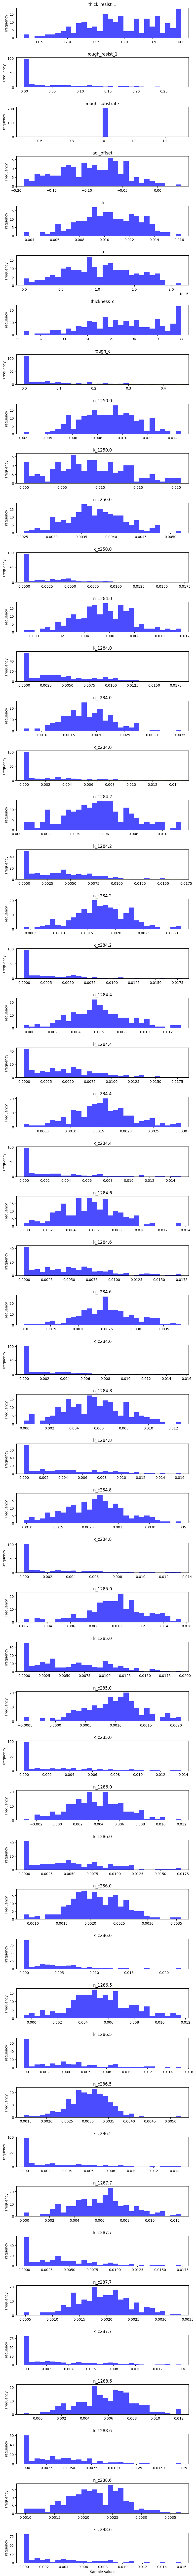

In [50]:
# plot the distribution of the starting walkers
import matplotlib.pyplot as plt
import numpy as np

# Number of parameters
num_params = samples.shape[1]

fig, axes = plt.subplots(num_params, 1, figsize=(8, 2 * num_params), sharex=False)

for i in range(num_params):
    axes[i].hist(samples[:, i], bins=30, alpha=0.7, color='b')
    axes[i].set_title(cols[i])
    axes[i].set_ylabel("Frequency")

axes[-1].set_xlabel("Sample Values")

plt.tight_layout()
plt.show()

In [22]:
lb, ub, x0

(array([3.20810703e+01, 2.32822809e-02, 2.17953726e-02, 3.11768825e-01,
        3.60000000e-02, 9.00000000e-07, 2.67365928e-03, 6.54602166e-04,
        1.28717179e-03, 7.14308113e-04, 1.17313739e-03, 7.33445659e-04,
        9.95802744e-04, 8.62045503e-04, 1.73734560e-03, 7.59304778e-04,
        1.45676565e-03, 8.81604755e-04, 3.40626470e-04, 7.41743865e-04,
        1.82573615e-03, 1.19658452e-03, 2.26199594e-03, 1.39066766e-03,
        1.30552362e-03, 1.51291915e-03, 1.45014866e-03, 1.63223797e-03]),
 array([3.92101970e+01, 2.84561211e-02, 2.66387887e-02, 3.81050787e-01,
        4.40000000e-02, 1.10000000e-06, 3.26780579e-03, 8.00069315e-04,
        1.57320997e-03, 8.73043249e-04, 1.43383459e-03, 8.96433584e-04,
        1.21709224e-03, 1.05361117e-03, 2.12342241e-03, 9.28039173e-04,
        1.78049136e-03, 1.07751692e-03, 4.16321242e-04, 9.06575834e-04,
        2.23145530e-03, 1.46249219e-03, 2.76466170e-03, 1.69970492e-03,
        1.59563998e-03, 1.84912340e-03, 1.77240392e-03, 1.9949

# Form here on some old stuff that needs to be cleaned up

In [18]:
df = pd.DataFrame()
x = result.x
sample_name = 'SOG1'
#filename = label + "_1layer_rel_err.h5" #-constraint
keys_fit = {'name': sample_name}
for ii in range(0, len(x)):
    keys_fit[cols[ii]] = x[ii]

# Append the new row to the DataFrame
df = pd.concat([df,pd.DataFrame(keys_fit, index=[0])], ignore_index=True)

print(df.columns)
# Assuming keys['E_uni'] is a list of values
rows = []

for E in keys['E_uni']:
    row = {'name':sample_name,
        'E': E}
    for col in df.columns:
        if str(E) in col:
            #print(col)
            new_col_name = col.replace(str(E), "")
            row[new_col_name] = df[col].values[0]  # Assuming you want the first value of the column
        else:
            row[col] = df[col].values[0]
    rows.append(row)

df_new = pd.DataFrame(rows)

for E in keys['E_uni']:
    columns_to_remove = [col for col in df_new.columns if str(E) in col]
    df_new.drop(columns=columns_to_remove, inplace=True)

# Resetting the index, if needed
df_new.reset_index(drop=True, inplace=True)
#df_new.to_csv('ALL_RESULTS_1layer_DE_1.csv', index=False)

Index(['name', 'thick_resist_1', 'rough_resist_1', 'rough_substrate',
       'aoi_offset', 'n_1250.0', 'k_1250.0', 'n_1284.0', 'k_1284.0',
       'n_1284.2', 'k_1284.2', 'n_1284.4', 'k_1284.4', 'n_1284.6', 'k_1284.6',
       'n_1284.8', 'k_1284.8', 'n_1285.0', 'k_1285.0', 'n_1286.0', 'k_1286.0',
       'n_1286.5', 'k_1286.5', 'n_1287.7', 'k_1287.7', 'n_1288.6', 'k_1288.6'],
      dtype='object')


In [36]:
df_read = pd.read_csv('ALL_RESULTS_1layer_DE_1.csv')

    # Append the new row to the DataFrame
df_save = pd.concat([df_read,df_new], ignore_index=True)
#df_read = df
df_save.to_csv('ALL_RESULTS_1layer_DE_1.csv', index=False)

In [24]:
for col in cols:
    print(col.replace(str(288.6),''))

thick_resist
rough_substrate
aoi_offset
n
k
rough_resist0


### Do DE every Energy and sample

#### Objective and domains

In [6]:

def objective_singleE(x,return_loglikli=False, return_all=False, con_layer=False): #, divergenz=divergenz,optical_constanst_oxide_layer=optical_constanst_oxide_layer):
    """
    In the function all the fit parameters are optimized.
    x: array containg the fit parameters that are optimzed.
    return_all: Turn to True if the calculated refelctivity and nk should be returned for a given x values
    con_layer: True or False depending if a conatamintion layer is part of the model
    """
    #writes the x values from an array into a dictonary
    for ii in range(0, len(x)):
        keys[cols[ii]] = x[ii]


    #intialize chi
    chi = 0
    loglikli = 0

    

    #print(layer)
    #prepare the arrays that will be returned
    if return_all:
        nk_E = []
        R_E = []
        R_exp_E = []
        layer_E = []
        rough_E = []
        #chi_E = []

    
    
    #Iteration over the different wavelength and the corresponding inner fit
    E = keys["E_uni"]
    x_E = np.where(energy_uni==E)[0][0]
    xrr_all = keys['xrr_all']
    wl = eVnm_converter(E)

    aoi = np.deg2rad(np.asarray(xrr_all['Theta'])) - np.deg2rad(keys['aoi_offset'])
    xrr = np.asarray(xrr_all['R'])
    sigma_sq = np.square(keys['a'] * xrr) + np.square(keys['b'])
    #sigma_sq = np.abs(xrr)
    if con_layer:
        layer = np.array([keys['thickness_c']])
        rough = np.array([keys['rough_c']])
    else:
        layer = np.array([])
        rough = np.array([])


        
    rough = np.append(rough,keys['rough_resist_1'])
    rough = np.append(rough,keys['rough_resist_2'])
    layer = np.append(layer,keys['thick_resist_1'])
    layer = np.append(layer,keys['thick_resist_2'])
    layer = np.append(layer,keys['thickness_toxid'])
    rough = np.append(rough,keys['rough_substrate'])
    rough = np.append(rough,keys['rough_substrate'])

    keys['n_o'] = 1-np.real(nk_sub_oxid[x_E])
    keys['k_o'] = np.imag(nk_sub_oxid[x_E])


    n = np.array([1 + 0 * 1j])
    if con_layer:
        n = np.append(n,1 - keys['n']*keys['density_c'] + keys['k']*np.abs(keys['density_c']) * 1j)
    n = np.append(n,1 - keys['n_1'] + keys['k_1'] * 1j) 
    n = np.append(n,1 - keys['n_2'] + keys['k_2'] * 1j)
    n = np.append(n,1 - keys['n_o'] + keys['k_o'] * 1j)
    n = np.append(n,nk_sub[x_E])


        
    rm, tm = mm.reflec_and_trans(n, wl, aoi, layer, rough, pol=1)  # polarization (either 1 for s-polarization or 0 for p-polarization)
    rm = np.square(np.abs(np.asarray(rm)))

    rm = rm +keys['darkcurrent']
    loglikli += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq)) - np.square(rm - xrr) / (2 * sigma_sq))
    chi += np.sum(np.square(rm - xrr) / (sigma_sq))

    #print('here innner finished')
    if return_all:
        nk_E.append(n)
        #chi_temp, rm_temp = objective_inner(res.x, wl, aoi, layer, rough, xrr, sigma_sq, i, return_R=True)
        R_E.append(rm)
        R_exp_E.append(xrr)
        layer_E.append(layer)
        rough_E.append(rough)

        # chi += np.sum(np.log(1 / np.sqrt(2 * np.pi * sigma_sq))) - chi_inner/2

    if return_all:
        return (nk_E), (R_E), chi, layer_E, rough_E, R_exp_E
    if return_loglikli:
        return loglikli
    
    return chi





In [7]:
domain_E_init = [
        {'name': 'n_1', 'x0': 0.00273, 'domain': (-5e-2,5e-2)},
        {'name': 'k_1', 'x0': 0.000171, 'domain': (0, 1e-2)},
        {'name': 'n_2', 'x0': 0.00273, 'domain': (-5e-2,5e-2)},
        {'name': 'k_2', 'x0': 0.000171, 'domain': (0, 1e-2)},
]
domain = [
        #{'name': 'a', 'x0': 0.04, 'domain': (0,0.2)},
        #{'name': 'b', 'x0': 2e-6, 'domain': (1e-11, 1e-3)},
        {'name': 'thick_resist_1', 'x0': 35, 'domain': (25, 45)},
        {'name': 'thick_resist_2', 'x0': 35, 'domain': (25, 45)},
        {'name': 'rough_substrate', 'x0': 0.01, 'domain': (0,2)},# 1.35},
        {'name': 'aoi_offset', 'x0': -0.105, 'domain': (-1,1)},      
        {'name': 'rough_resist_1', 'x0': 0.5, 'domain': (0,2)},  
        {'name': 'rough_resist_2', 'x0': 0.5, 'domain': (0,2)} 
    ]


    
con_layer = False #Set to true if a contamtion layer should be added to the model.

if con_layer:
    domain_E_init.append({'name': 'thickness_c', 'x0': 1, 'domain': (0,4)})
    domain.append({'name': 'rough_c', 'x0': 0.1, 'domain': (0,3)})
    domain_E_init.append({'name': 'density_c', 'x0': 1.8, 'domain': (0,5)})


#Make a list containg the name of the fi parameters
cols = [do['name'] for do in domain]
##Define the upper and lower boundries by evaluating the domains
lb = [do['domain'][0] for do in domain]
ub = [do['domain'][1] for do in domain]
bounds = [do['domain'] for do in domain]
x0_ = [do['x0'] for do in domain]


for do in domain_E_init:
    lb.append(do['domain'][0])
    ub.append(do['domain'][1]) #ub.append(do['domain'][1])
    x0_.append(do['x0'])
    bounds.append(do['domain'])
    cols.append(do['name'])               
        

lb = np.asarray(lb)
ub = np.asarray(ub)
x0_ = np.asarray(x0_)
x0_start = x0_.copy()
keys = {
    'darkcurrent': 0,
    'a': 0.04529578438348669,
    'b': 2.5366001043504797e-5,
    'aoi_offset':0,
    'thickness_toxid':1.5,    
}



#### Do DE

In [8]:
test = False
use_old_fits = True
if use_old_fits:
    path = './DE/'
    onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('csv') and f.startswith('')]
    print(onlyfiles_keys)
    df_all = []
    for file in onlyfiles_keys:#[0::5]:

        file = join(path, file)
        df = pd.read_csv(file) 

        df_all.append(df)
    df_all = pd.concat(df_all, ignore_index=True)


for file in labels_uni:
    print('start new file ',file)
    xrr_all_temp = combined_df[combined_df['file_name'] == file]
    energy_uni = np.unique(xrr_all_temp['Energy'])

    for energy in energy_uni:
        print('new energy ',energy)
        subset = xrr_all_temp[xrr_all_temp['Energy'] == energy]
        keys['E_uni'] = energy
        keys['xrr_all'] = subset

        if test:
            objective_singleE(x0_, con_layer=con_layer)

        

        else:
            retries = 0
            max_retries = 10  # Limit retries to 2
            result = None

            if use_old_fits:
                try:
                    mask = (df_all['name'] == file) & (df_all['Energy'] == energy)
                    x0_ = []
                    for col in cols:
                        x0_.append(df_all[mask][col].values[0])
                    chi_test = df_all[mask]['chi_sq'].values[0]-100
                    #if df_all[mask]['chi_sq'].values[0] <1000:
                    #    print('fit was succesfull before')
                    #    break
                except:
                    x0_ = x0_start
                    chi_test = 100000

            else:
                chi_test = 100000

            result = differential_evolution(objective_singleE, bounds, x0=x0_)
            result_temp = result#.copy()

            while retries < max_retries:
                #try:
                result = differential_evolution(objective_singleE, bounds, x0=x0_,polish=True)
                #except:
                #    result = differential_evolution(objective_singleE, bounds, x0=x0_start)
                #print(result.fun)

                if result.fun < chi_test and result.fun < result_temp.fun:
                    print('save: ',file, result.fun)
                    df = pd.DataFrame()
                    x = result.x
                    x0_ = x
                    keys_fit = {
                        'name': file,
                        'Energy': energy,
                        'chi_sq': result.fun
                    }
                    for ii in range(len(x)):
                        keys_fit[cols[ii].replace(str(energy), '')] = x[ii]

                    # Append the new row to the DataFrame
                    df = pd.concat([df, pd.DataFrame(keys_fit, index=[0])], ignore_index=True)
                    df.to_csv('./DE/' + file + '_' + str(energy) + '_ALL_energy_1layer_DE_1.csv', index=False)
                    break  # Exit loop if result is acceptable
                print(f"Retrying optimization (Attempt {retries})...")
                if result.fun < result_temp.fun:
                    result_temp = result
                retries += 1
                x0_ = x0_start

            # Process the result
            if result_temp.fun < chi_test:
                print('save 2: ',file, result_temp.fun)
                df = pd.DataFrame()
                x = result_temp.x
                x0_ = x
                keys_fit = {
                    'name': file,
                    'Energy': energy,
                    'chi_sq': result_temp.fun
                }
                for ii in range(len(x)):
                    keys_fit[cols[ii].replace(str(energy), '')] = x[ii]

                # Append the new row to the DataFrame
                df = pd.concat([df, pd.DataFrame(keys_fit, index=[0])], ignore_index=True)
                df.to_csv('./DE/' + file + '_' + str(energy) + '_ALL_energy_1layer_DE_1.csv', index=False)
            

['SOC3_003205_288.6_ALL_energy_1layer_DE_1.csv', 'SOG4_002941_288.6_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOC_SOG2_4254_284.0_ALL_energy_1layer_DE_1.csv', 'SOG1_002938_288.0_ALL_energy_1layer_DE.csv', 'SOC3_003205_285.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOG2_002939_285.0_ALL_energy_1layer_DE_1.csv', 'SOC5_003207_284.8_ALL_energy_1layer_DE_1.csv', 'SOC5_003207_288.6_ALL_energy_1layer_DE_1.csv', 'SOG2_002939_284.0_ALL_energy_1layer_DE.csv', 'UL_SOC_SOG1_4253_285.0_ALL_energy_1layer_DE_1.csv', 'SOC2_003204_285.0_ALL_energy_1layer_DE_1.csv', 'SOG4_002941_288.4_ALL_energy_1layer_DE.csv', 'SOC2_003204_250.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC4_003206_288.6_ALL_energy_1layer_DE_1.csv', 'SOC5_003207_288.6_ALL_energy_1layer_DE_1_start3deg.csv', 'TOK_exps_UL_SOC_SOG1_4255_284.0_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOC_SOG2_4254_286.5_ALL_energy_1layer_DE_1.csv', 'SOG4_002941_287.0_ALL_energy_1layer_DE_1.csv', 'UL_SOC_SOG1_4253_284.2_ALL_energy_1layer_DE_1.csv', 'SOC3_00320

#### Do MCMC

In [15]:
def lnprior(x):
    for i, y in enumerate(x):
        if y < lb[i] or y > ub[i]:
            return -np.inf
    return 0.0

def lnprob(x):
    lp = lnprior(x)

    if not np.isfinite(lp):
        return -np.inf
    return objective_singleE(x, return_loglikli=True, con_layer=con_layer) + lp  # lnlike(x) #lp

In [16]:
ndim = len(lb)
progressdir = './MCMC/CCD_1layer/'
#os.rmdir(progressdir)
try:
    os.mkdir(progressdir)
except:
    print('Folder exits')
print('# MCMC run {} #'.format(progressdir))

Folder exits
# MCMC run ./MCMC/CCD_1layer/ #


In [17]:
#####Import Start postion
startdir = progressdir#'./40FITpy36_05'
#chain = np.load('{}/mcmc_chain_02.npy'.format(startdir))[:,-1]
#reach=np.where(chain[0,:,0] == 0)[0]-1
#chain = chain[:,reach]
#print(chain)


nwalkers = len(lb)*2+100
chain = [np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]

In [18]:
def mcmc(lb, ub,pool, backend=None, start_pos=chain, nwalkers=nwalkers, steps=900001, burn_in=1000, **kwargs):
    ndim = len(lb)

    #start_pos = [np.random.normal(x_test, np.abs(x_test) * 0.05) for i in range(nwalkers)]
    #start_pos = [np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]
    #start_pos = [np.random.normal(x0_,x0_*0.05) for i in range(nwalkers)]
    #print(np.shape(start_pos))
    #print(np.shape([np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,backend=backend, pool=pool, **kwargs)
    sampler.run_mcmc(start_pos, steps, thin = 100)
    #sampler.run_mcmc(None, steps, thin = 100)

    return sampler,

In [19]:
test = False
use_old_fits = True
energy_uni_reduced = np.array([284,287.7]) #energy_uni
if use_old_fits:
    path = './DE/'
    onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('csv') and f.startswith('')]
    print(onlyfiles_keys)
    df_all = []
    for file in onlyfiles_keys:#[0::5]:

        file = join(path, file)
        df = pd.read_csv(file) 

        df_all.append(df)
    df_all = pd.concat(df_all, ignore_index=True)


for file in labels_uni:
    
    xrr_all_temp = combined_df[combined_df['file_name'] == file]
    energy_uni = np.unique(xrr_all_temp['Energy'])

    for energy in energy_uni_reduced:
        filename = file+ '_'+str(energy) + "_1layer_01.h5"  #-constraint
        print(filename)
        backend = emcee.backends.HDFBackend(join(progressdir,filename))
        subset = xrr_all_temp[xrr_all_temp['Energy'] == energy]
        keys['E_uni'] = energy
        keys['xrr_all'] = subset

        
        if test:
            objective_singleE(x0_, con_layer=con_layer)
        

        else:


            if use_old_fits:
                mask = (df_all['name'] == file) & (df_all['Energy'] == energy)
                x0_ = [0.05,1e-5]
                for col in cols[2:]:
                    x0_.append(df_all[mask][col].values[0])
                mean =x0_
                if test:
                    objective_singleE(x0_, con_layer=con_layer)
            else:
                result = differential_evolution(objective_singleE, bounds, x0=x0_)
                mean= result.x


            std_dev = 0.1 # Standard deviation 
            samples = np.random.normal(loc=mean, scale=std_dev, size=(nwalkers, len(mean)))
            samples = np.clip(samples, lb, ub)
            #print(np.shape(samples))
            chain = [np.random.uniform(lb, ub, ndim) for i in range(nwalkers)]
            #print(np.shape(chain))

            
            with Pool(39) as pool:
                #sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
                #start = time.time()
                #sampler.run_mcmc(initial, nsteps, progress=True)
                
                sampler = mcmc(lb,ub,pool, backend=backend, start_pos=samples, nwalkers=nwalkers, steps=100001, burn_in=1000)




['SOC3_003205_288.6_ALL_energy_1layer_DE_1.csv', 'SOC3_003205_285.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC5_003207_284.8_ALL_energy_1layer_DE_1.csv', 'SOC5_003207_288.6_ALL_energy_1layer_DE_1.csv', 'SOC2_003204_285.0_ALL_energy_1layer_DE_1.csv', 'SOC2_003204_250.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC4_003206_288.6_ALL_energy_1layer_DE_1.csv', 'SOC5_003207_288.6_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC3_003205_285.0_ALL_energy_1layer_DE_1.csv', 'SOC3_003205_288.6_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC2_003204_284.8_ALL_energy_1layer_DE_1.csv', 'SOC4_003206_285.0_ALL_energy_1layer_DE_1.csv', 'SOC1_003203_284.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC1_003203_250.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC2_003204_250.0_ALL_energy_1layer_DE_1.csv', 'SOC3_003205_284.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC3_003205_250.0_ALL_energy_1layer_DE_1_start3deg.csv', 'SOC1_003203_284.8_ALL_energy_1layer_DE_1.csv', 'SOC4_003206_285.0_ALL_energy_1layer_DE_1_start3deg.csv

SOC1_003203_287.7_1layer_01.h5
SOC2_003204_284.0_1layer_01.h5
SOC2_003204_287.7_1layer_01.h5
SOC3_003205_284.0_1layer_01.h5
SOC3_003205_287.7_1layer_01.h5
SOC4_003206_284.0_1layer_01.h5
SOC4_003206_287.7_1layer_01.h5
SOC5_003207_284.0_1layer_01.h5
SOC5_003207_287.7_1layer_01.h5


#### Look at results

In [10]:
path = './DE/'
onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('csv') and f.startswith('TOK_exps_UL_SOG4')]
print(onlyfiles_keys)
df_all = []
for file in onlyfiles_keys:#[0::5]:

    file = join(path, file)
    df = pd.read_csv(file) 

    df_all.append(df)
df_all = pd.concat(df_all, ignore_index=True)

['TOK_exps_UL_SOG4_4256_284.0_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_284.2_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_250.0_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_286.0_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_286.5_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_288.6_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_287.7_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_285.0_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_284.6_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_285.5_ALL_energy_1layer_DE_1.csv', 'TOK_exps_UL_SOG4_4256_287.0_ALL_energy_1layer_DE_1.csv']


In [21]:
path = './MCMC/'
onlyfiles_keys = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('MCMC.csv') and f.startswith('A')]
print(onlyfiles_keys)
df_all = []
for file in onlyfiles_keys:#[0::5]:

    file = join(path, file)
    df = pd.read_csv(file) 

    df_all.append(df)
df_all = pd.concat(df_all, ignore_index=True)

['ALL_RESULTS_1layer_MCMC.csv']


In [19]:
df_all.dtypes
#E_uni = np.unique(df_all['Energy'])

name                object
Energy             float64
chi_sq             float64
thick_resist       float64
rough_substrate    float64
aoi_offset         float64
rough_resist       float64
n                  float64
k                  float64
a                  float64
b                  float64
dtype: object

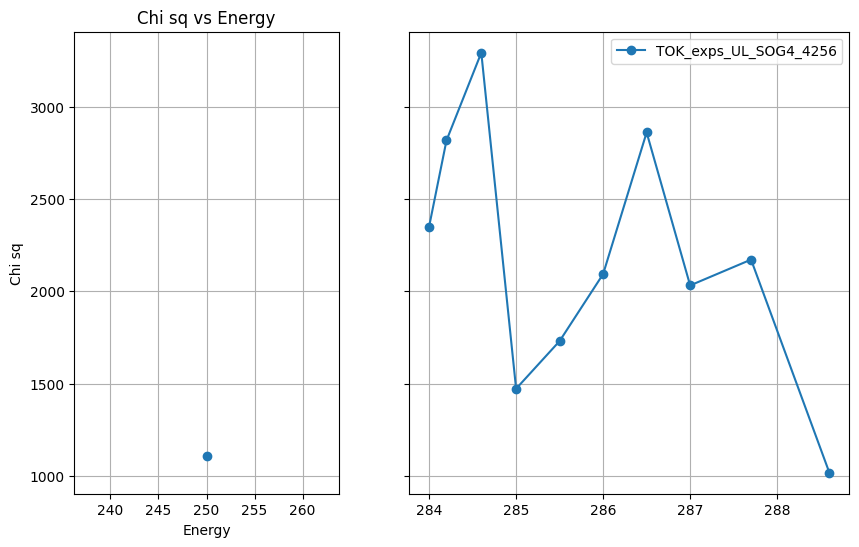

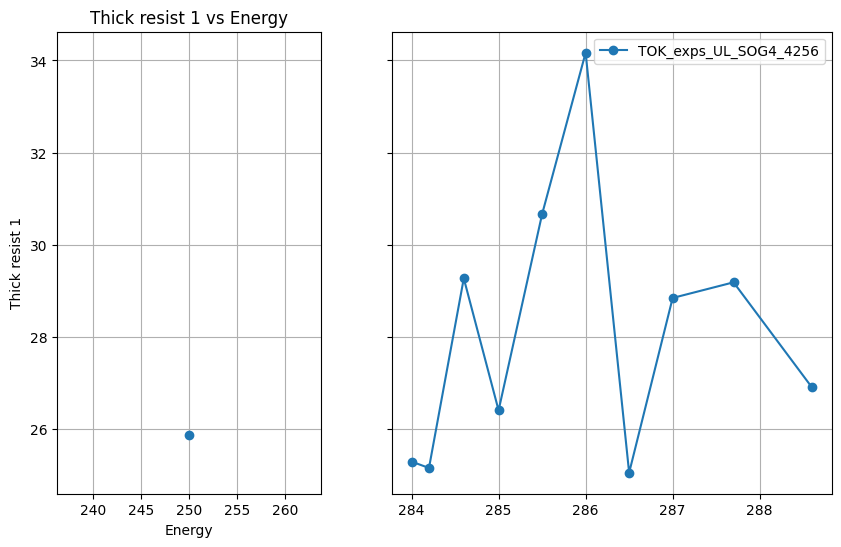

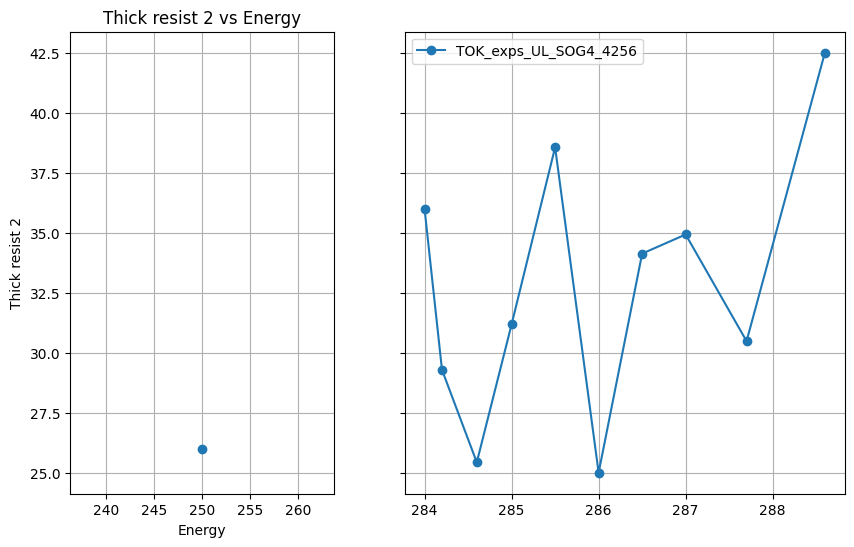

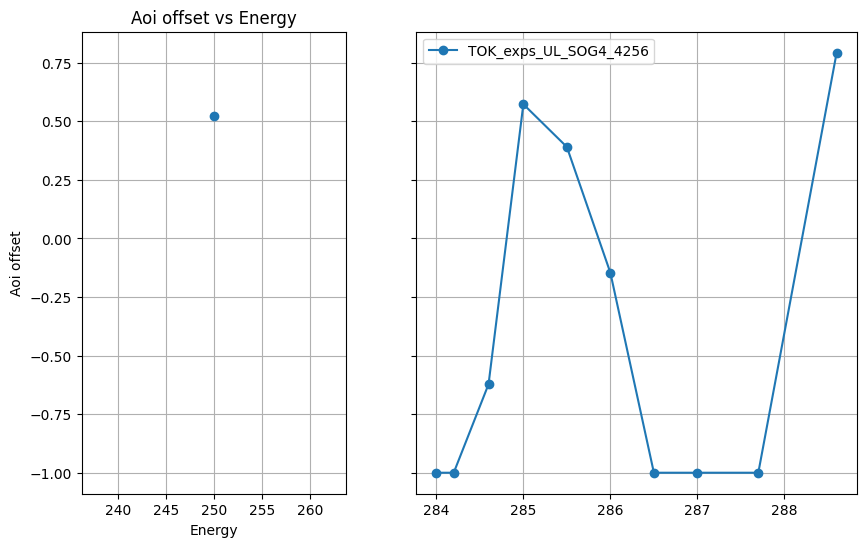

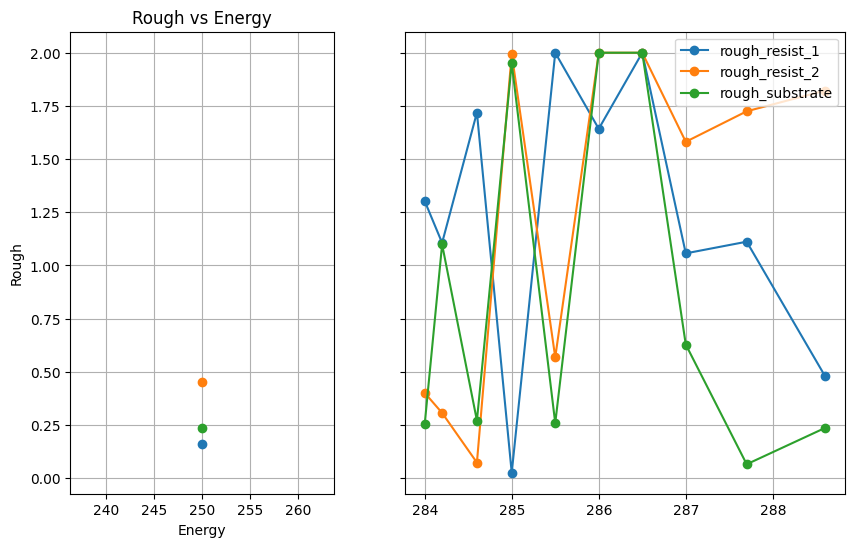

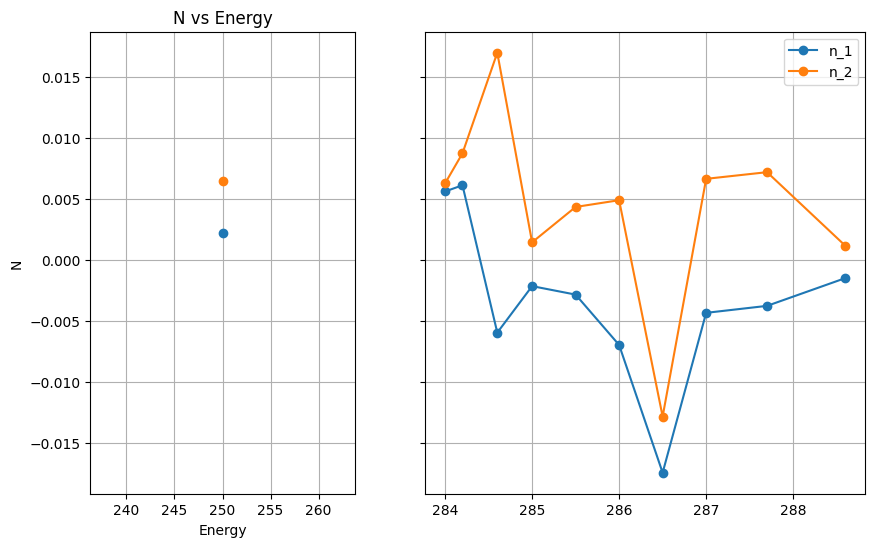

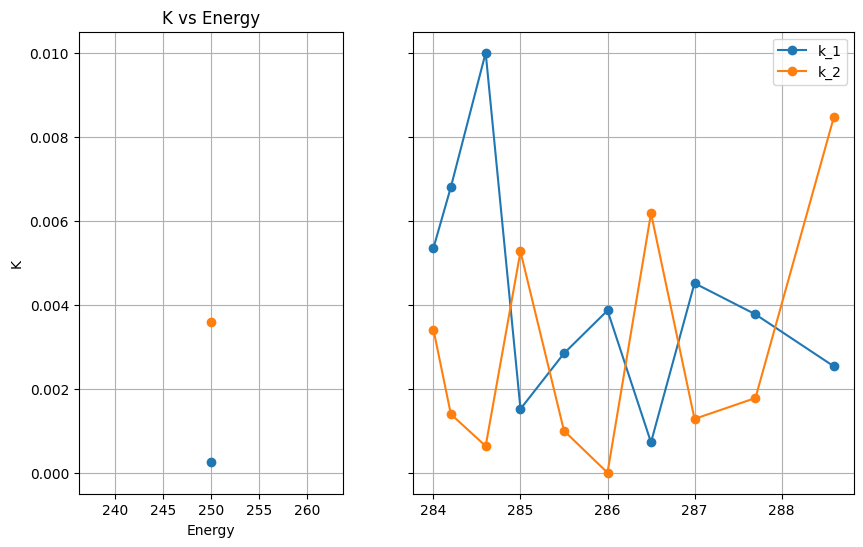

In [11]:
import matplotlib.pyplot as plt
import numpy as np

columns_to_plot = [
    'chi_sq', 'thick_resist_1','thick_resist_2',  'aoi_offset', 
    'rough', 'n', 'k'
]

for column in columns_to_plot:
    # Create subplots for broken x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6), gridspec_kw={'width_ratios': [3, 5]})

    for name in np.unique(df_all['name']):
        if column == 'n' or column == 'k':
            name_temp = column +'_1'
            subset = df_all[df_all['name'] == name]
            subset = subset.sort_values(by="Energy")  # Ensure data is sorted
            
            # Plot the left side of the x-axis (Energy ≤ 255)
            ax1.plot(subset["Energy"][subset["Energy"] <= 255], 
                    subset[name_temp][subset["Energy"] <= 255], 'o-', label=name_temp)

            # Plot the right side of the x-axis (Energy ≥ 280)
            ax2.plot(subset["Energy"][subset["Energy"] >= 280], 
                    subset[name_temp][subset["Energy"] >= 280], 'o-', label=name_temp)
            
            name_temp = column +'_2'
            
            # Plot the left side of the x-axis (Energy ≤ 255)
            ax1.plot(subset["Energy"][subset["Energy"] <= 255], 
                    subset[name_temp][subset["Energy"] <= 255], 'o-', label=name_temp)

            # Plot the right side of the x-axis (Energy ≥ 280)
            ax2.plot(subset["Energy"][subset["Energy"] >= 280], 
                    subset[name_temp][subset["Energy"] >= 280], 'o-', label=name_temp)
            
        elif column == 'rough': 

            subset = df_all[df_all['name'] == name]
            subset = subset.sort_values(by="Energy")  # Ensure data is sorted

            name_temp = column +'_resist_1'
                            # Plot the left side of the x-axis (Energy ≤ 255)
            ax1.plot(subset["Energy"][subset["Energy"] <= 255], 
                    subset[name_temp][subset["Energy"] <= 255], 'o-', label=name_temp)

            # Plot the right side of the x-axis (Energy ≥ 280)
            ax2.plot(subset["Energy"][subset["Energy"] >= 280], 
                    subset[name_temp][subset["Energy"] >= 280], 'o-', label=name_temp)
            
            name_temp = column +'_resist_2'
                            # Plot the left side of the x-axis (Energy ≤ 255)
            ax1.plot(subset["Energy"][subset["Energy"] <= 255], 
                    subset[name_temp][subset["Energy"] <= 255], 'o-', label=name_temp)

            # Plot the right side of the x-axis (Energy ≥ 280)
            ax2.plot(subset["Energy"][subset["Energy"] >= 280], 
                    subset[name_temp][subset["Energy"] >= 280], 'o-', label=name_temp)
            
            name_temp = column +'_substrate'
                            # Plot the left side of the x-axis (Energy ≤ 255)
            ax1.plot(subset["Energy"][subset["Energy"] <= 255], 
                    subset[name_temp][subset["Energy"] <= 255], 'o-', label=name_temp)

            # Plot the right side of the x-axis (Energy ≥ 280)
            ax2.plot(subset["Energy"][subset["Energy"] >= 280], 
                    subset[name_temp][subset["Energy"] >= 280], 'o-', label=name_temp)
        
        else:
            subset = df_all[df_all['name'] == name]
            subset = subset.sort_values(by="Energy")  # Ensure data is sorted
            
            # Plot the left side of the x-axis (Energy ≤ 255)
            ax1.plot(subset["Energy"][subset["Energy"] <= 255], 
                    subset[column][subset["Energy"] <= 255], 'o-', label=name)

            # Plot the right side of the x-axis (Energy ≥ 280)
            ax2.plot(subset["Energy"][subset["Energy"] >= 280], 
                    subset[column][subset["Energy"] >= 280], 'o-', label=name)

    # Customize ax1 (left subplot)
    #ax1.set_xlim(200, 255)
    ax1.set_xlabel("Energy")
    ax1.set_ylabel(column.replace('_', ' ').capitalize())
    ax1.set_title(f"{column.replace('_', ' ').capitalize()} vs Energy")
    ax1.grid()
    ax2.grid()

    # Customize ax2 (right subplot)
    ax2.set_xlim
    plt.legend()

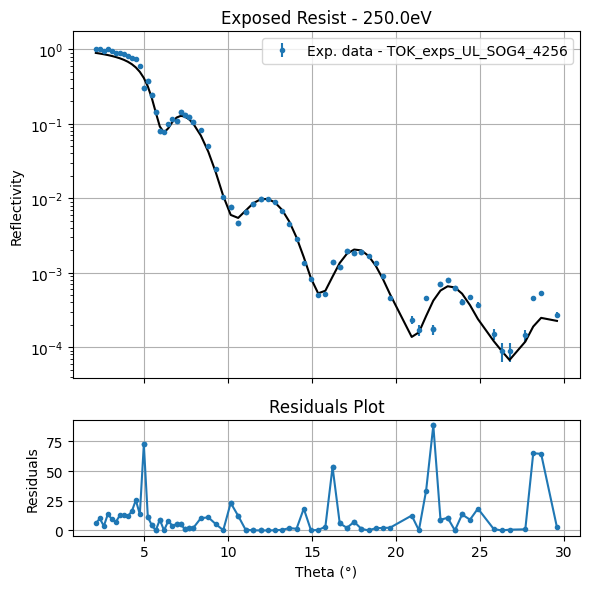

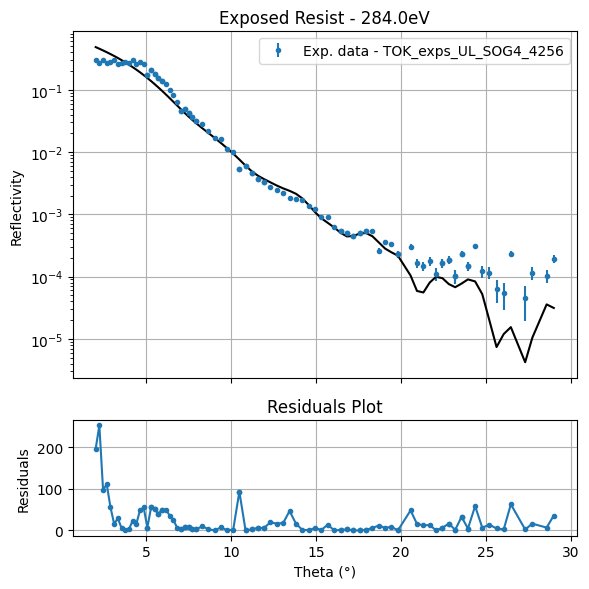

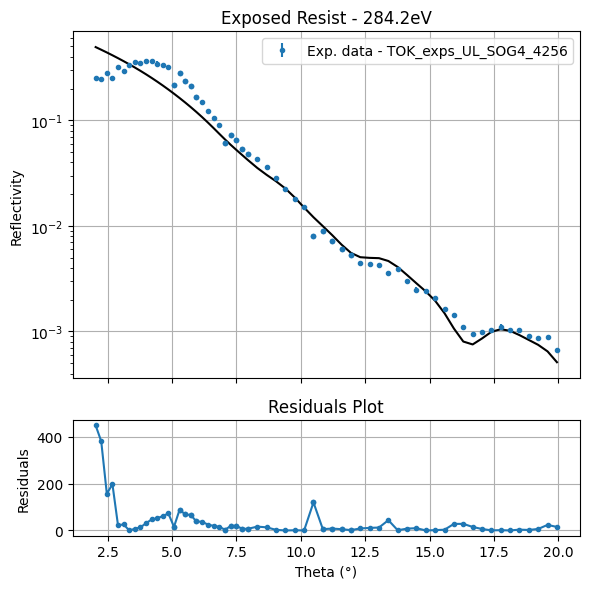

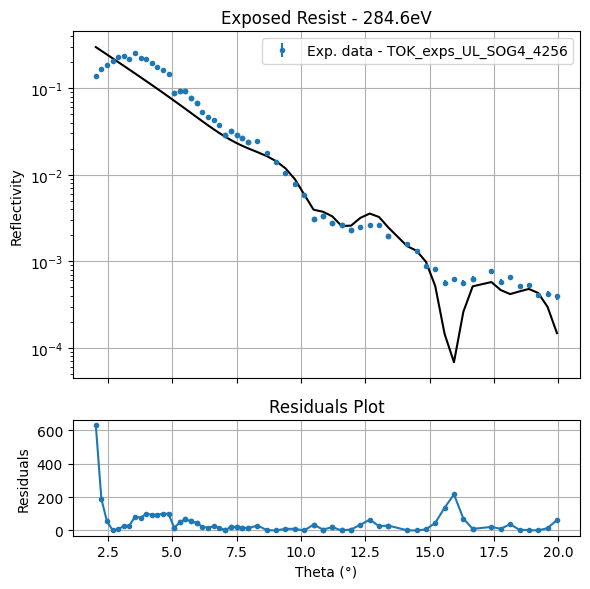

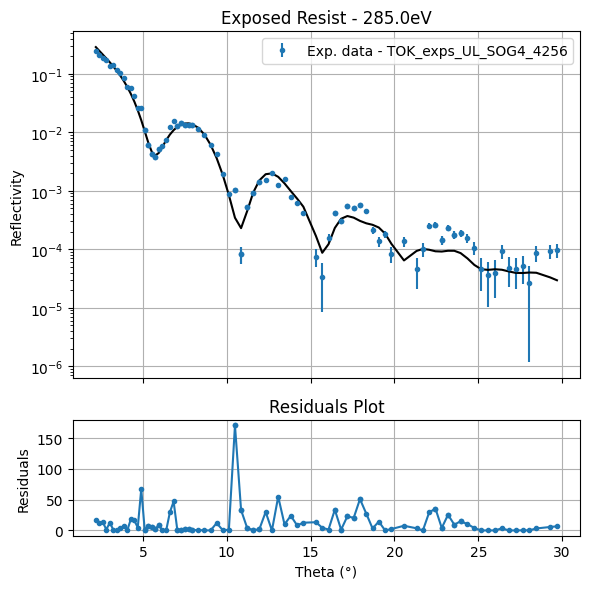

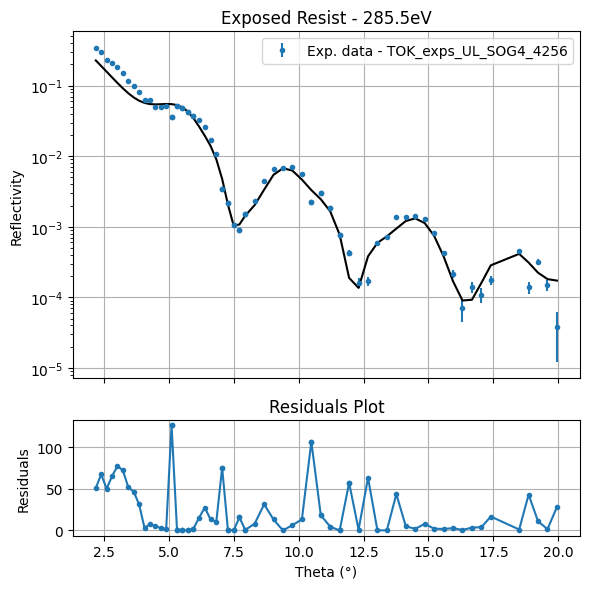

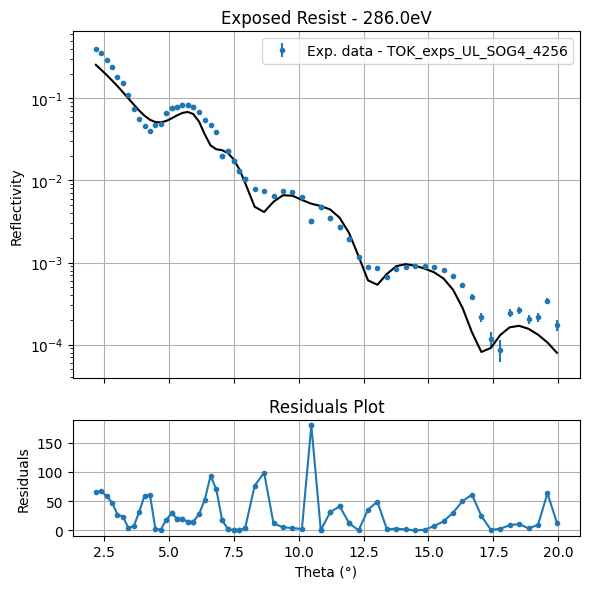

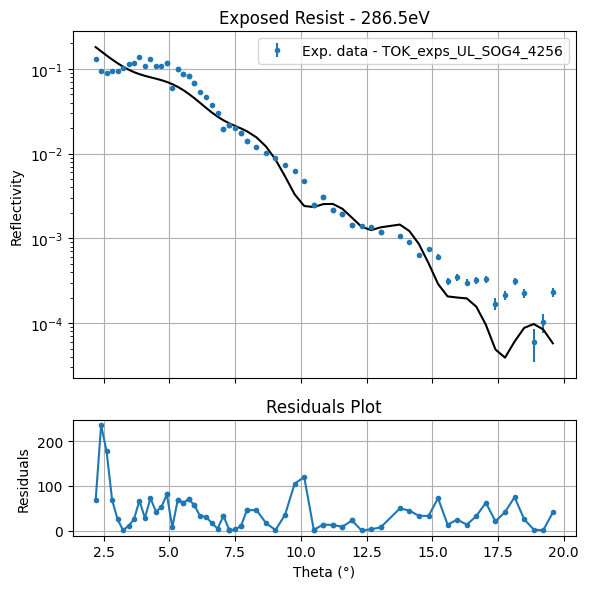

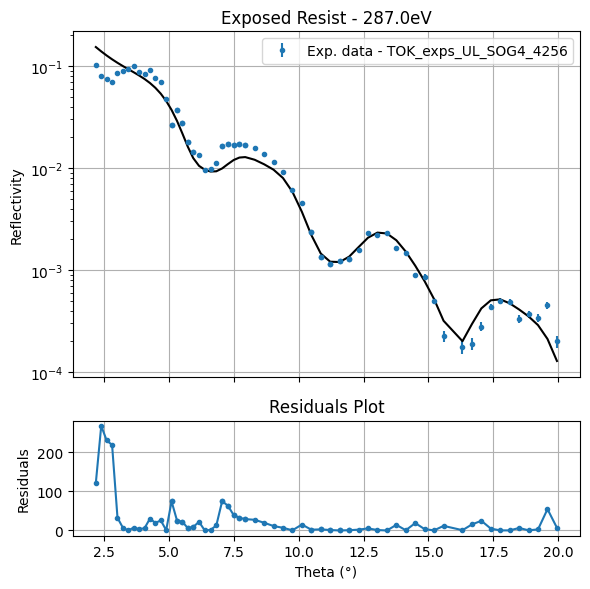

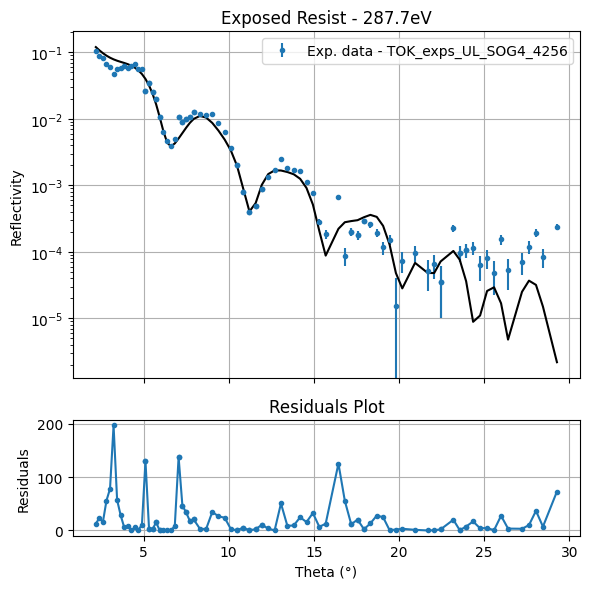

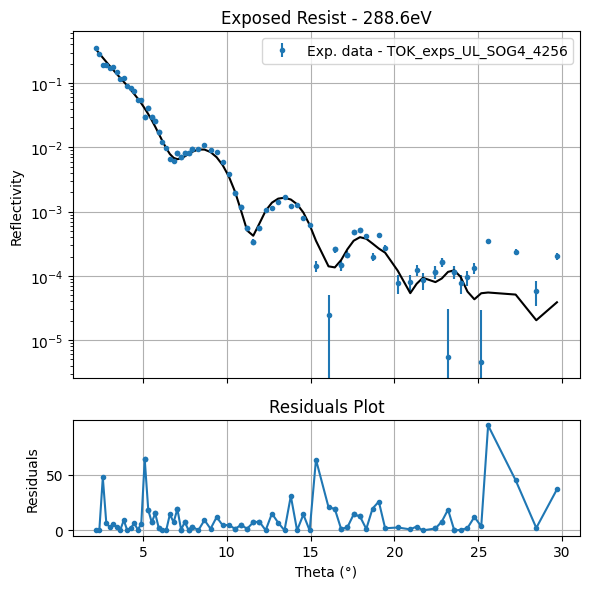

In [12]:
for file in labels_uni:
    xrr_all_temp = combined_df[combined_df['file_name'] == file]
    energy_uni = np.unique(xrr_all_temp['Energy'])

    #fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    i == 0
    for energy in energy_uni:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        subset = xrr_all_temp[xrr_all_temp['Energy'] == energy]
        keys['E_uni'] = energy
        keys['xrr_all'] = subset
        mask = (df_all['name'] == file) & (df_all['Energy'] == energy)
        x = []
        for col in cols:
            x.append(df_all[mask][col].values[0])

        (nk_E), (R_E), chi, layer_E, rough_E, R_exp_E = objective_singleE(x, con_layer=con_layer, return_all=True)
        absolute_error = np.sqrt(np.square(keys['a'] * R_exp_E[0].T) + np.square(keys['b'] )) #* xrr_all['theta']
        
        # Plot experimental data with error bars
        ax1.errorbar(keys['xrr_all']['Theta'], R_exp_E[0].T, yerr=absolute_error, fmt='.', label='Exp. data - ' + file)
        
        #ax1.plot(xrr_all['Theta'], xrr_all['R'], '.', label='Exp. data - '+str(E)+' eV')
        if i == 0:
            ax1.plot(keys['xrr_all']['Theta'], R_E[0].T, '-',color='black', label='Mod. data')
        else:
            ax1.plot(keys['xrr_all']['Theta'], R_E[0].T, '-',color='black')

        residuals = np.square(R_exp_E[0].T - R_E[0].T)/np.square(absolute_error) #np.square(rm - xrr) / (sigma_sq)
        ax2.plot(keys['xrr_all']['Theta'], residuals, '.-', label='Residuals - '+file)



        i+=1

        ax1.set_yscale('log')
        ax1.set_ylabel('Reflectivity')
        ax1.set_title('Exposed Resist - ' + str(energy) +'eV')
        ax1.legend()
        ax1.grid(True)

        ax2.set_xlabel('Theta (°)')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residuals Plot')
        #ax2.set_yscale('log')
        #ax2.set_ylim(-0.25,0.25)
        #ax1.legend(loc='center right')#, bbox_to_anchor=(1, 0.5))
        ax2.grid(True)
        
        plt.tight_layout()



In [34]:
import matplotlib.pyplot as plt
import numpy as np

#keys = {}
i = 0  # Initialize counter

for file in labels_uni:
    xrr_all_temp = combined_df[combined_df['file_name'] == file]
    energy_uni = np.unique(xrr_all_temp['Energy'])

    for energy in energy_uni:
        subset = xrr_all_temp[xrr_all_temp['Energy'] == energy]
        keys['E_uni'] = energy
        keys['xrr_all'] = subset
        mask = (df_all['name'] == name) & (df_all['Energy'] == energy)
        
        # Ensure cols is defined
        x = []
        for col in cols:
            x.append(df_all[mask][col].values[0])

        (nk_E), (R_E), chi, layer_E, rough_E, R_exp_E = objective_singleE(x, con_layer=con_layer, return_all=True)
        absolute_error = np.sqrt(np.square(keys['a'] * R_exp_E[0].T) + np.square(keys['b']))

        # Create a figure for each energy with stacked subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

        # Plot experimental data with error bars
        ax1.errorbar(keys['xrr_all']['Theta'], R_exp_E[0].T, yerr=absolute_error, fmt='.', label=f'Exp. data - {name} nm')
        ax1.plot(keys['xrr_all']['Theta'], R_E[0].T, '-', color='black', label='Mod. data')

        residuals = np.square(R_exp_E[0].T - R_E[0].T) / np.square(absolute_error)
        ax2.plot(keys['xrr_all']['Theta'], residuals, '.-', label=f'Residuals - {name} nm')

        # Customize the reflectivity plot
        ax1.set_yscale('log')
        ax1.set_ylabel('Reflectivity')
        ax1.set_title('Exposed Resist - homogeneous')
        ax1.legend()
        ax1.grid(True)

        # Customize the residuals plot
        ax2.set_xlabel('Theta (°)')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residuals Plot')
        ax2.grid(True)

        # Final adjustments
        plt.tight_layout()
        plt.show()

KeyError: 'a'

In [58]:
nk_E

array([[0.0188549 , 0.0018069 ],
       [0.02329269, 0.00397649],
       [0.02310543, 0.00386771],
       [0.02697521, 0.00480955]])

### Values provided by different person
File	delta	beta	Thickness	Sigma	fmin
output_12.5      0.0185813      0.0024974   31.10   0.00   1.50   0.00  0.485E-04
output_13.5a      0.0219425      0.0032159   31.01   0.00   1.50   0.00  0.600E-04
output_13.5b      0.0219531      0.0032206   31.06   0.00   1.50   0.00  0.582E-04
output_14.5      0.0255474      0.0040562   30.84   0.00   1.50   0.00  0.802E-04